# C33100 Stage-1 EDA

# Valve Failures C33100

    C33100 1ST STAGE CYLINDER 4 VALVES         17 May 2019 - 21 May 2019
    
                

In [222]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from scipy import stats
import statsmodels.api as sm

pd.set_option('display.max_columns', None)

import tensorflow as tf
from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler, StandardScaler

mpl.rcParams['figure.figsize'] = (18,5)
mpl.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')

import plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

from platform import python_version

print("TF version : ", tf.__version__)
print("python version", python_version())

TF version :  2.3.0
python version 3.8.0


In [223]:
((7*1700)/60)*20

3966.666666666667

In [224]:
pd.read_csv('stg-1.csv')


asset_no     time_stamp  FI3317.PV  PI3301.PV  TI3317.PV  DPI3301.PV  \
0         C33100  1546322400000   9.191452   5.802198       33.0       45.00   
1         C33100  1546322460000   9.194123   5.326007       33.0       45.00   
2         C33100  1546322520000   9.189599   5.289377       33.0       45.00   
3         C33100  1546322580000   8.742044   5.062271       33.0       45.00   
4         C33100  1546322640000   8.744074   5.047619       33.0       45.00   
...          ...            ...        ...        ...        ...         ...   
1821604   C33100  1662009946000   7.750000   5.840000       62.0       46.00   
1821605   C33100  1662010006000   7.770000   5.810000       62.0       46.00   
1821606   C33100  1662010066000   7.710000   5.740000       62.0       46.00   
1821607   C33100  1662010126000   7.510000   5.470000       62.0       46.00   
1821608   C33100  1662010186000   7.680000   5.600000       62.0       45.23   

         TI3310.PV  TI3315A.PV  TI3315B.PV  PI3315.PV  \
0        35.404022  193.045013  186.248505      51.00   
1        35.458664  192.993897  186.251175      50.00   
2        35.406860  192.945282  186.200378      50.00   
3        35.409241  192.996826  186.202621      50.00   
4        35.409695  192.896668  186.151825      50.00   
...            ...         ...         ...        ...   
1821604  62.630000  201.330000  211.620000      52.00   
1821605  62.630000  201.380000  211.630000      52.00   
1821606  62.650000  201.440000  211.650000      52.00   
1821607  62.620000  201.470000  211.740000      51.23   
1821608  62.540000  201.490000  211.820000      51.00   

         OPERATING_STATE_C33100V2_4760  
0                                  3.0  
1                                  3.0  
2                                  3.0  
3                                  3.0  
4                                  3.0  
...                                ...  
1821604                            NaN  
1821605                            NaN  
1821606                            NaN  
1821607                            NaN  
1821608                            NaN  

[1821609 rows x 11 columns]

In [225]:
COL_NAMES_MAPPING = {
                    'FI3317.PV' : 'SUCTION_FLOW',
                    'PI3301.PV' : 'SUCTION_PRESSURE',
                    'TI3317.PV': 'ANNBAR_TEMPERATURE',
                    'DPI3301.PV': 'ROD_LOAD_DP',
                    'TI3310.PV' :'SUCTION_THERMOCOUPLE',
                    'TI3315A':'DISCHARGE_CYLINDER_#2',
                    'TI3315B':'DISCHARGE_CYLINDER_#4',
                    'PI3315':'DISCHARGE_PRESSURE',
                    'OPERATING_STATE_C33100V2_4760': 'OPERATING_STATE' 
                    }
for i,j in COL_NAMES_MAPPING.items():
    print(j.upper())

SUCTION_FLOW
SUCTION_PRESSURE
ANNBAR_TEMPERATURE
ROD_LOAD_DP
SUCTION_THERMOCOUPLE
DISCHARGE_CYLINDER_#2
DISCHARGE_CYLINDER_#4
DISCHARGE_PRESSURE
OPERATING_STATE


In [226]:
# df.to_csv('C33100_stg_1_raw_params.csv', index=True)

In [227]:
def convert_F_to_K(a):
    return ((a - 32) / 1.8) + 273.15

def convert_PSIG_to_PSIA(a):
    return a + 14.7

def efficiency(avg_sucT_inK, avg_disT_inK, pressure_ratio, k):
    '''Pass first input as suction temperature, next one as discharge temperature, next one pressure ratio and k'''
    return (avg_sucT_inK / (avg_disT_inK - avg_sucT_inK)) * ((pressure_ratio) ** ((k - 1) / k) - 1)

4 hr resample & try

In [127]:
%%time

FILE_PATH = 'stg-1.csv'
COL_NAMES_MAPPING = {
                    'FI3317.PV' : 'SUCTION_FLOW',
                    'PI3301.PV' : 'SUCTION_PRESSURE',
                    'TI3317.PV': 'ANNBAR_TEMPERATURE',
                    'DPI3301.PV': 'ROD_LOAD_DP',
                    'TI3310.PV' :'SUCTION_THERMOCOUPLE',
                    'TI3315A.PV':'DISCHARGE_CYLINDER_#2',
                    'TI3315B.PV':'DISCHARGE_CYLINDER_#4',
                    'PI3315.PV':'DISCHARGE_PRESSURE',
                    'OPERATING_STATE_C33100V2_4760': 'OPERATING_STATE' 
}

cols_to_be_used = ['time_stamp', 'asset_no', 'SUCTION_FLOW', 'SUCTION_PRESSURE', 
                   'SUCTION_THERMOCOUPLE', 'DISCHARGE_CYLINDER_#2',
                   'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE', 
                   'OPERATING_STATE']


RESAMPLING_FREQUENCY = '4h'  # 15T, 2h , 2d etc...

# FAILURES
START_DATE_1 = datetime(2019, 5, 17)  # year, month, date
END_DATE_1 = datetime(2019, 5, 21)    # year, month, date

# START_DATE_2 = datetime(2019, 4, 19)  # year, month, date
# END_DATE_2 = datetime(2019, 4, 23)    # year, month, date


# Reading the csv data file
df = pd.read_csv(FILE_PATH)

# Renaming the columns for better understanding
df.rename(columns= COL_NAMES_MAPPING, inplace=True)
df = df[cols_to_be_used]

# Creating different features
df['DELTA_PRESSURE'] = df['DISCHARGE_PRESSURE'] - df['SUCTION_PRESSURE']
df['PRESSURE_RATIO'] = df['DISCHARGE_PRESSURE']/df['SUCTION_PRESSURE']
# avg_stg_1_suc_T = convert_F_to_K(df['SUCTION_THERMOCOUPLE']) 
# avg_stg_1_disc_T = (convert_F_to_K(df['DISCHARGE_CYLINDER_#2']) + convert_F_to_K(df['DISCHARGE_CYLINDER_#4'])) / 2
# stg1_efficiency = efficiency(avg_stg_1_suc_T, avg_stg_1_disc_T, df['PRESSURE_RATIO'], 1.2)
# df['STG1_EFF'] = stg1_efficiency
df['DELTA_TEMP_CYLINDER'] = abs(df['DISCHARGE_CYLINDER_#2']-df['DISCHARGE_CYLINDER_#4'])


# df['Suction_Pressure'] = df['Discharge_Pressure'] - df['Differential_Pressure']
# df['Pressure_ratio'] = df['Discharge_Pressure']/df['Suction_Pressure']
# df['Delta_Pressure'] = df['Discharge_Pressure'] - df['Suction_Pressure']

# Converting to Human timestamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'], unit='ms')

# Filtering the Operaing States
df = df[(df['OPERATING_STATE']==3)]
df.drop(['asset_no', 'OPERATING_STATE'], axis=1, inplace=True)

# Resampling to 4 hour level
df.set_index('time_stamp', inplace=True)
print("Data before resampling ==> {}".format(df.shape))
df = df.resample(RESAMPLING_FREQUENCY).mean().dropna()
print("Data after resampling ==> {}".format(df.shape))
df


Data before resampling ==> (682732, 9)
Data after resampling ==> (3493, 9)
Wall time: 2.96 s


SUCTION_FLOW  SUCTION_PRESSURE  SUCTION_THERMOCOUPLE  \
time_stamp                                                                  
2019-01-01 04:00:00      8.814003          5.194933             35.289555   
2019-01-01 08:00:00      8.655781          4.830067             34.667764   
2019-01-01 12:00:00      8.359643          4.267552             34.085032   
2019-01-01 16:00:00      8.361713          4.305464             35.959932   
2019-01-01 20:00:00      8.744045          5.074695             36.917346   
...                           ...               ...                   ...   
2022-08-11 00:00:00      8.153333          6.650000             63.218333   
2022-08-11 12:00:00      7.898000          6.342000             59.780000   
2022-08-11 16:00:00      8.086250          6.850000             61.765625   
2022-08-14 20:00:00      7.822917          6.442500             70.593333   
2022-08-20 20:00:00      7.728667          6.334000             73.650000   

                     DISCHARGE_CYLINDER_#2  DISCHARGE_CYLINDER_#4  \
time_stamp                                                          
2019-01-01 04:00:00             192.875322             186.063029   
2019-01-01 08:00:00             192.719074             185.645106   
2019-01-01 12:00:00             192.336219             185.414438   
2019-01-01 16:00:00             194.349793             188.311890   
2019-01-01 20:00:00             194.256512             188.875008   
...                                    ...                    ...   
2022-08-11 00:00:00             206.203333             210.913333   
2022-08-11 12:00:00             207.424000             209.160000   
2022-08-11 16:00:00             207.928125             211.352500   
2022-08-14 20:00:00             205.095833             218.900417   
2022-08-20 20:00:00             191.882667             199.892667   

                     DISCHARGE_PRESSURE  DELTA_PRESSURE  PRESSURE_RATIO  \
time_stamp                                                                
2019-01-01 04:00:00           50.333333       45.138401        9.712325   
2019-01-01 08:00:00           49.170833       44.340766       10.216795   
2019-01-01 12:00:00           47.579167       43.311615       11.195648   
2019-01-01 16:00:00           47.741667       43.436203       11.236782   
2019-01-01 20:00:00           49.716667       44.641972        9.857936   
...                                 ...             ...             ...   
2022-08-11 00:00:00           54.963333       48.313333        8.266781   
2022-08-11 12:00:00           54.000000       47.658000        8.519989   
2022-08-11 16:00:00           55.656562       48.806562        8.145562   
2022-08-14 20:00:00           55.282083       48.839583        8.582683   
2022-08-20 20:00:00           53.333333       46.999333        8.431373   

                     DELTA_TEMP_CYLINDER  
time_stamp                                
2019-01-01 04:00:00             6.812293  
2019-01-01 08:00:00             7.073968  
2019-01-01 12:00:00             6.921781  
2019-01-01 16:00:00             6.037903  
2019-01-01 20:00:00             5.381505  
...                                  ...  
2022-08-11 00:00:00             4.710000  
2022-08-11 12:00:00             1.736000  
2022-08-11 16:00:00             3.424375  
2022-08-14 20:00:00            13.804583  
2022-08-20 20:00:00             8.010000  

[3493 rows x 9 columns]

In [128]:
df

SUCTION_FLOW  SUCTION_PRESSURE  SUCTION_THERMOCOUPLE  \
time_stamp                                                                  
2019-01-01 04:00:00      8.814003          5.194933             35.289555   
2019-01-01 08:00:00      8.655781          4.830067             34.667764   
2019-01-01 12:00:00      8.359643          4.267552             34.085032   
2019-01-01 16:00:00      8.361713          4.305464             35.959932   
2019-01-01 20:00:00      8.744045          5.074695             36.917346   
...                           ...               ...                   ...   
2022-08-11 00:00:00      8.153333          6.650000             63.218333   
2022-08-11 12:00:00      7.898000          6.342000             59.780000   
2022-08-11 16:00:00      8.086250          6.850000             61.765625   
2022-08-14 20:00:00      7.822917          6.442500             70.593333   
2022-08-20 20:00:00      7.728667          6.334000             73.650000   

                     DISCHARGE_CYLINDER_#2  DISCHARGE_CYLINDER_#4  \
time_stamp                                                          
2019-01-01 04:00:00             192.875322             186.063029   
2019-01-01 08:00:00             192.719074             185.645106   
2019-01-01 12:00:00             192.336219             185.414438   
2019-01-01 16:00:00             194.349793             188.311890   
2019-01-01 20:00:00             194.256512             188.875008   
...                                    ...                    ...   
2022-08-11 00:00:00             206.203333             210.913333   
2022-08-11 12:00:00             207.424000             209.160000   
2022-08-11 16:00:00             207.928125             211.352500   
2022-08-14 20:00:00             205.095833             218.900417   
2022-08-20 20:00:00             191.882667             199.892667   

                     DISCHARGE_PRESSURE  DELTA_PRESSURE  PRESSURE_RATIO  \
time_stamp                                                                
2019-01-01 04:00:00           50.333333       45.138401        9.712325   
2019-01-01 08:00:00           49.170833       44.340766       10.216795   
2019-01-01 12:00:00           47.579167       43.311615       11.195648   
2019-01-01 16:00:00           47.741667       43.436203       11.236782   
2019-01-01 20:00:00           49.716667       44.641972        9.857936   
...                                 ...             ...             ...   
2022-08-11 00:00:00           54.963333       48.313333        8.266781   
2022-08-11 12:00:00           54.000000       47.658000        8.519989   
2022-08-11 16:00:00           55.656562       48.806562        8.145562   
2022-08-14 20:00:00           55.282083       48.839583        8.582683   
2022-08-20 20:00:00           53.333333       46.999333        8.431373   

                     DELTA_TEMP_CYLINDER  
time_stamp                                
2019-01-01 04:00:00             6.812293  
2019-01-01 08:00:00             7.073968  
2019-01-01 12:00:00             6.921781  
2019-01-01 16:00:00             6.037903  
2019-01-01 20:00:00             5.381505  
...                                  ...  
2022-08-11 00:00:00             4.710000  
2022-08-11 12:00:00             1.736000  
2022-08-11 16:00:00             3.424375  
2022-08-14 20:00:00            13.804583  
2022-08-20 20:00:00             8.010000  

[3493 rows x 9 columns]

In [129]:
# df.to_csv('C33100_stg_1_raw_params.csv', index=True)

### Checking for NULL values

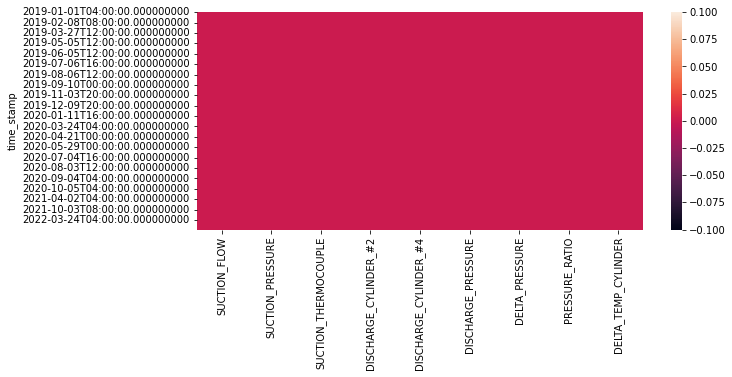

In [130]:
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull())
plt.show()

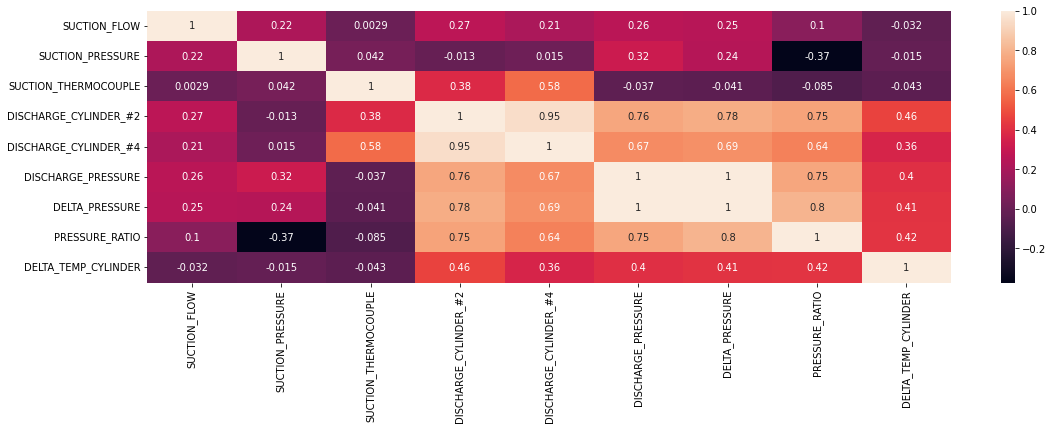

In [131]:
sns.heatmap(df.corr(), annot=True)
plt.show()

In [132]:
df.shape

(3493, 9)

In [133]:
df.describe().T

count        mean        std         min         25%  \
SUCTION_FLOW           3493.0    8.864373   0.586464    0.000000    8.590000   
SUCTION_PRESSURE       3493.0    6.212744   0.598000    3.533578    5.779090   
SUCTION_THERMOCOUPLE   3493.0   49.612327  10.406811   26.306839   40.611704   
DISCHARGE_CYLINDER_#2  3493.0  198.841131  14.315744  127.998085  188.340000   
DISCHARGE_CYLINDER_#4  3493.0  198.185055  12.806116  126.004082  189.395653   
DISCHARGE_PRESSURE     3493.0   52.263254   7.179039    0.000000   45.966667   
DELTA_PRESSURE         3493.0   46.050510   7.011542   -7.637363   39.821581   
PRESSURE_RATIO         3493.0    8.474899   1.198706    0.000000    7.587844   
DELTA_TEMP_CYLINDER    3493.0    3.180581   3.345957    0.033173    0.949229   

                              50%         75%         max  
SUCTION_FLOW             8.887209    9.168935   16.545580  
SUCTION_PRESSURE         6.142385    6.572924    7.987399  
SUCTION_THERMOCOUPLE    50.350867   58.220420   84.204819  
DISCHARGE_CYLINDER_#2  196.485715  210.904983  240.785543  
DISCHARGE_CYLINDER_#4  197.428711  207.824908  230.157785  
DISCHARGE_PRESSURE      51.337500   59.312500   67.562500  
DELTA_PRESSURE          44.756609   53.618407   59.716209  
PRESSURE_RATIO           8.108579    9.427819   13.181117  
DELTA_TEMP_CYLINDER      2.157383    4.318000   31.162133

## Applying EWM to see the trends (smoothening)

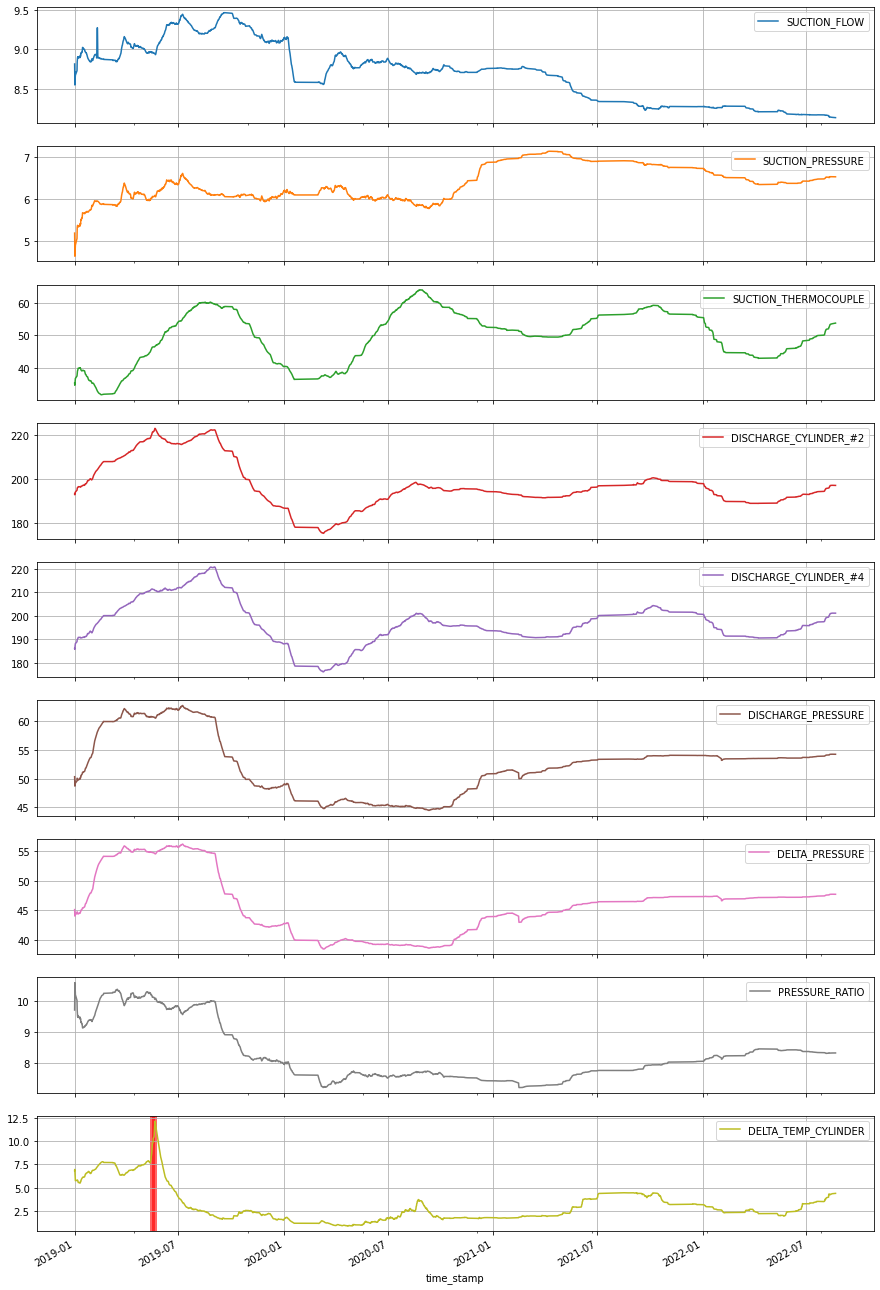

In [134]:
df.ewm(alpha=0.01).mean().plot(subplots=True, figsize=(15, 25))
plt.axvspan(START_DATE_1, END_DATE_1, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)
# plt.axvspan(START_DATE_2, END_DATE_2, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)

plt.show()

In [135]:
df.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER'],
      dtype='object')

In [136]:
int(len(df.columns)/2+1)

5

In [137]:
# axs.shape

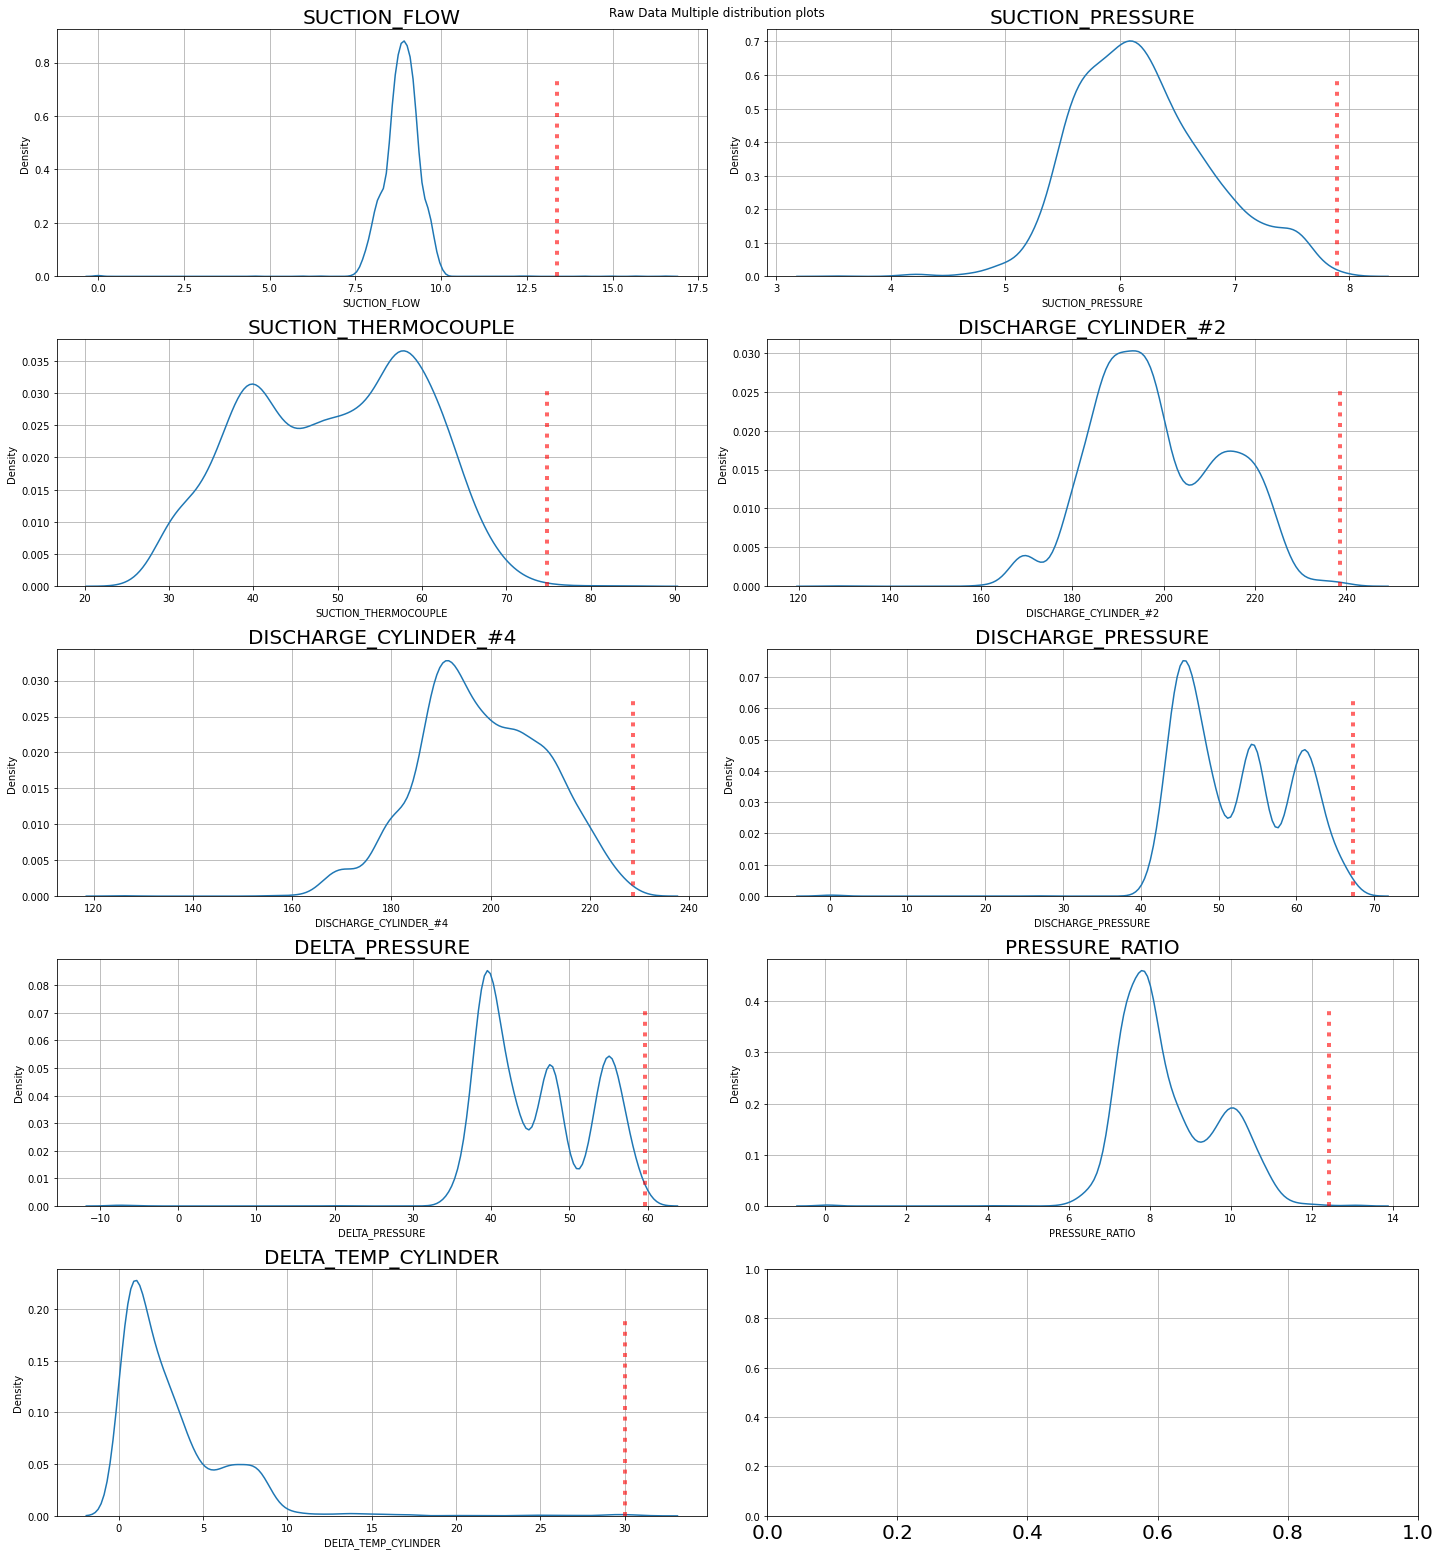

<Figure size 1296x360 with 0 Axes>

In [138]:
fig, axs = plt.subplots(int(len(df.columns)/2)+1, 2,figsize=(20,22))
fig.suptitle('Raw Data Multiple distribution plots')

col_num = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        if col_num >= len(df.columns):
            break
        
        temp = df.iloc[:, col_num]
        sns.kdeplot(temp, ax=axs[i, j])
        #axs[i, j].hist(temp,bins=100)
        #axs[i, j].plot(temp)
        per = np.percentile(temp, 99.9)
        axs[i, j].axvline(per, alpha = 0.6, ymax = 0.80, linestyle = ":", color='red',lw=4)
        #axs[i, j].set_xticklabels(temp.eucl_dist_3_norm_cc,fontsize=20)
        
        del temp # Clearing memory
        axs[i, j].set_title(str(df.columns[col_num]), fontsize=20) 
        col_num = col_num + 1
fig.tight_layout()
plt.xticks(fontsize=20)
plt.show()
plt.clf()


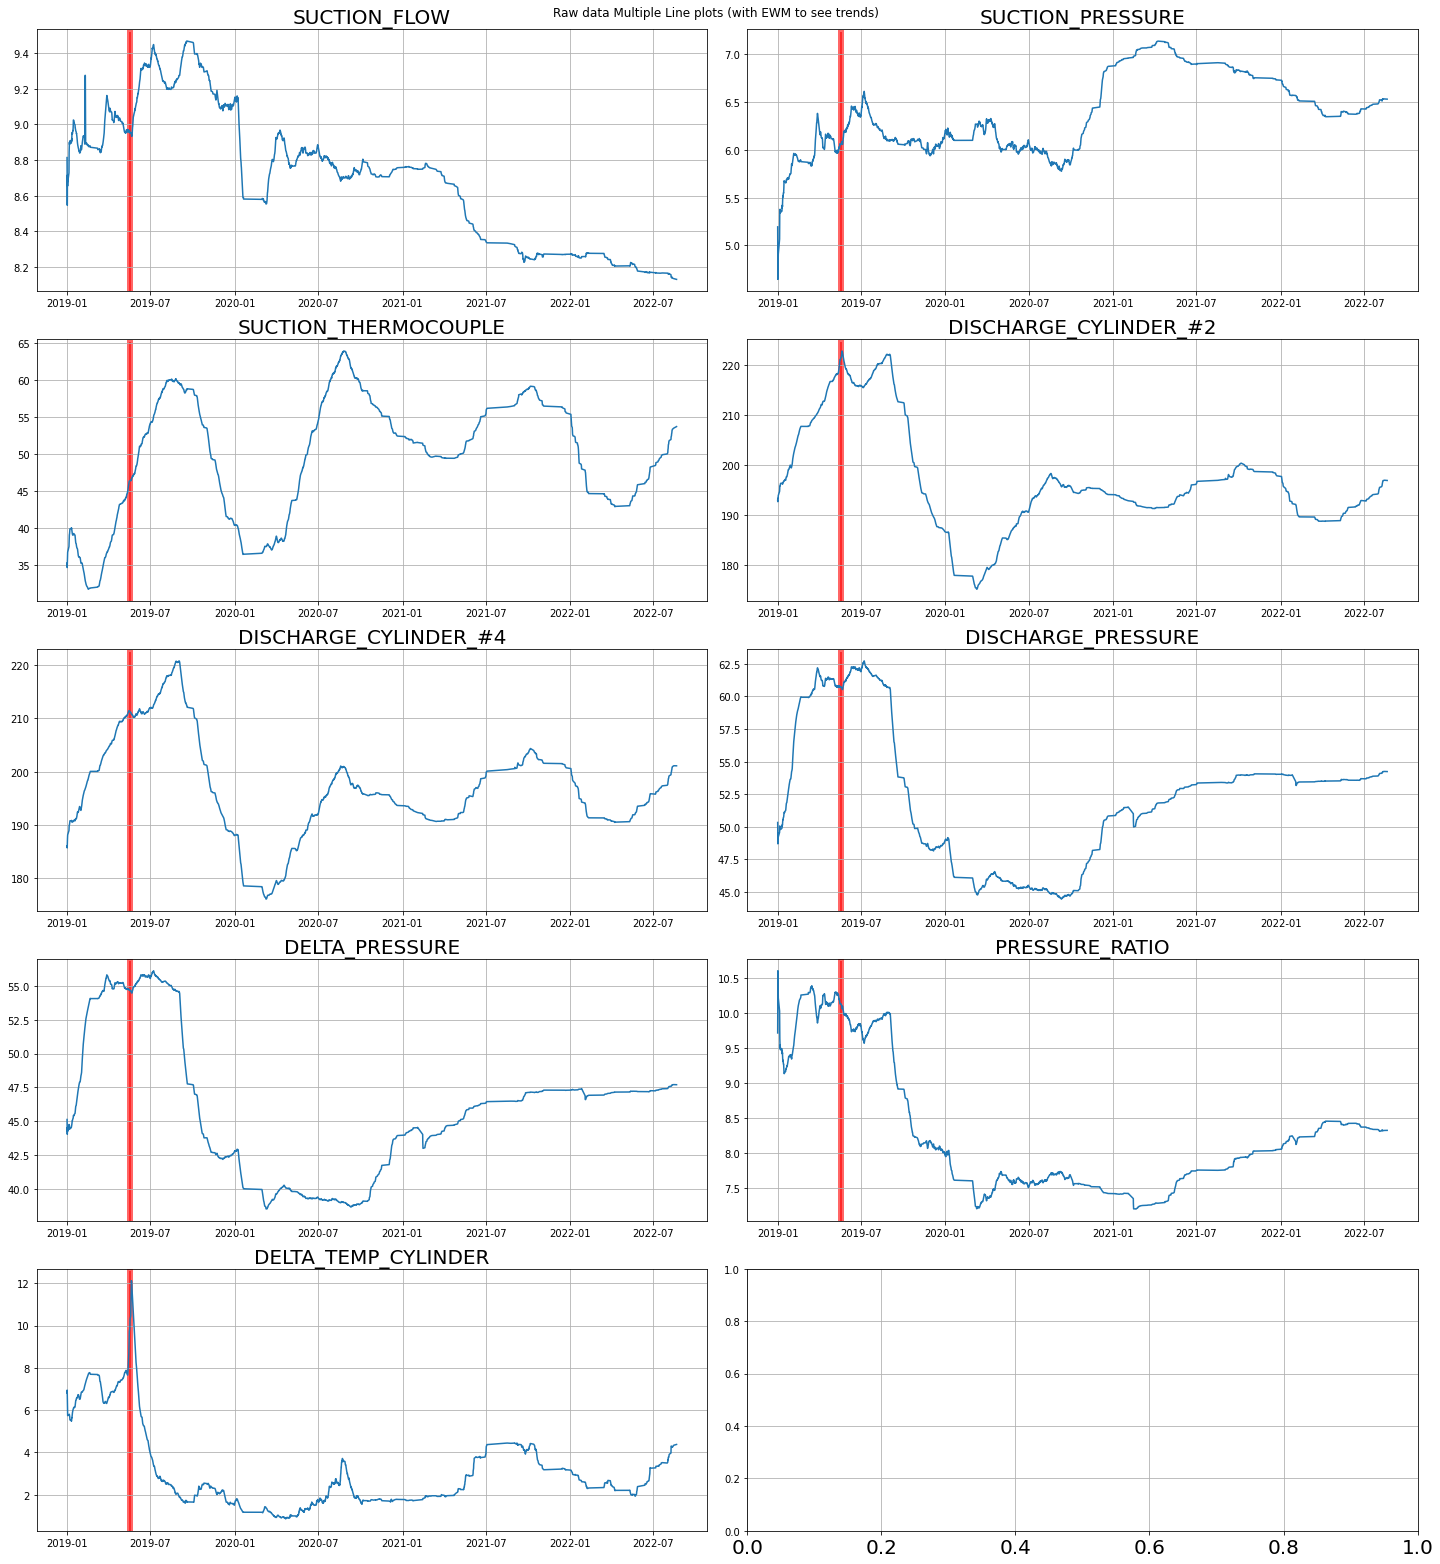

<Figure size 1296x360 with 0 Axes>

In [139]:
fig, axs = plt.subplots( int(len(df.columns)/2)+1, 2,figsize=(20,22))
fig.suptitle('Raw data Multiple Line plots (with EWM to see trends)')

col_num = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        if col_num >= len(df.columns):
            break
        
        temp = df.iloc[:, col_num].ewm(alpha=0.01).mean()
        #sns.kdeplot(temp, ax=axs[i, j])
        #axs[i, j].hist(temp,bins=100)
        axs[i, j].plot(temp)
        #per = np.percentile(temp, 99.9)
        #axs[i, j].axvline(datetime(2020, 3, 30), alpha = 0.6, ymax = 0.80, linestyle = "-", color='red',lw=4)
        axs[i, j].axvspan(START_DATE_1, END_DATE_1, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)
        #axs[i, j].axvspan(START_DATE_2, END_DATE_2, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)
        #axs[i, j].set_xticklabels(temp.eucl_dist_3_norm_cc,fontsize=20)
        
        del temp # Clearing memory
        axs[i,j].set_title(str(df.columns[col_num]), fontsize=20) 
        col_num = col_num + 1
fig.tight_layout()
plt.xticks(fontsize=20)
plt.show()
plt.clf()


In [140]:
for dta in df.columns:
    print(dta)

SUCTION_FLOW
SUCTION_PRESSURE
SUCTION_THERMOCOUPLE
DISCHARGE_CYLINDER_#2
DISCHARGE_CYLINDER_#4
DISCHARGE_PRESSURE
DELTA_PRESSURE
PRESSURE_RATIO
DELTA_TEMP_CYLINDER


# Power Transformation

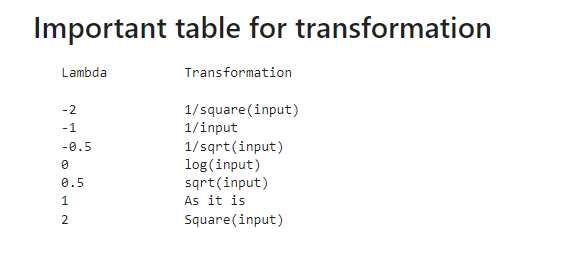

In [141]:
df.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER'],
      dtype='object')

In [142]:
# lst = df.columns.to_list()
# lst.remove('SUCTION_FLOW')
# lst

In [143]:
df.replace(0,0.0001, inplace=True)

In [144]:
# _, l = stats.boxcox(abs(df[col]))

SUCTION_FLOW  ===>  1.447584821088733
SUCTION_FLOW  New (As it is)===>  1.447584821088733


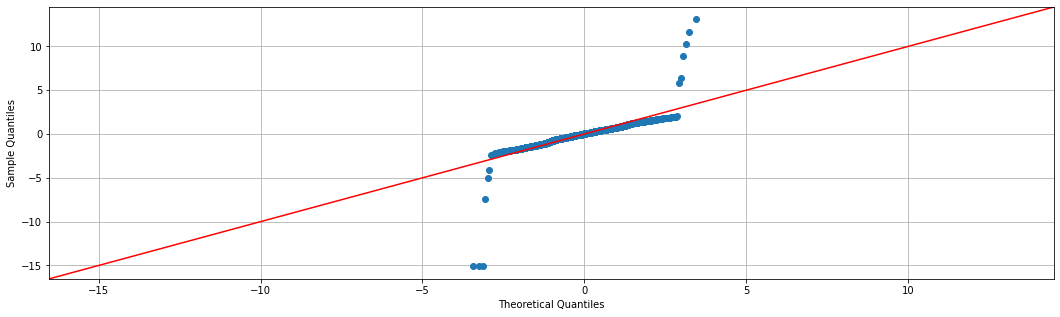

SUCTION_PRESSURE  ===>  -0.24675894004185006
SUCTION_PRESSURE  New (applying 1/log(input)) ===>  -0.6183388963388008


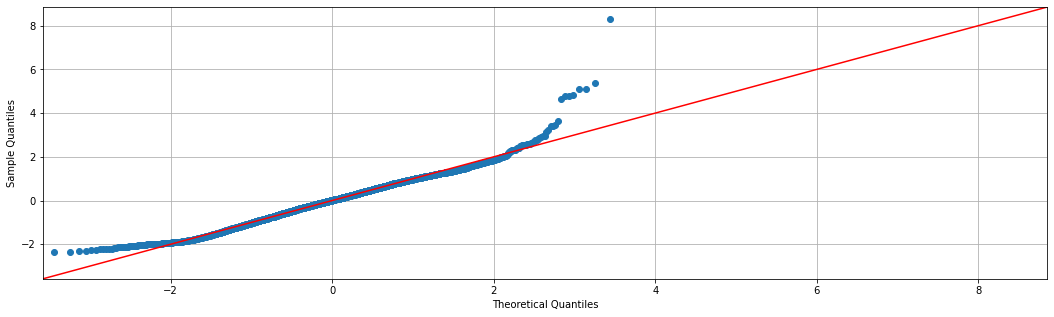

SUCTION_THERMOCOUPLE  ===>  1.0559669423333382
SUCTION_THERMOCOUPLE  New (As it is)===>  1.0559669423333382


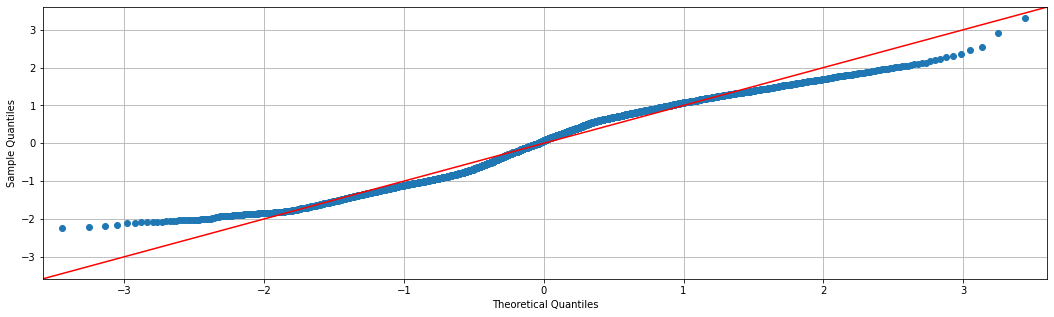

DISCHARGE_CYLINDER_#2  ===>  -0.05554930160933675
DISCHARGE_CYLINDER_#2  New (applying 1/log(input)) ===>  -0.6830959014931411


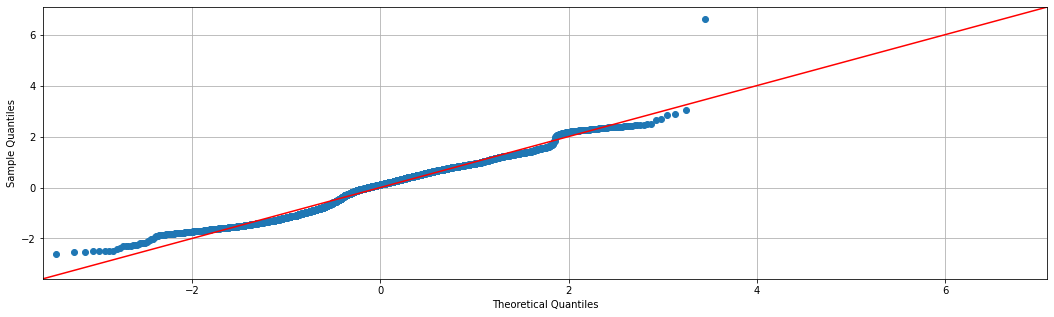

DISCHARGE_CYLINDER_#4  ===>  1.3718587217472027
DISCHARGE_CYLINDER_#4  New (As it is)===>  1.3718587217472027


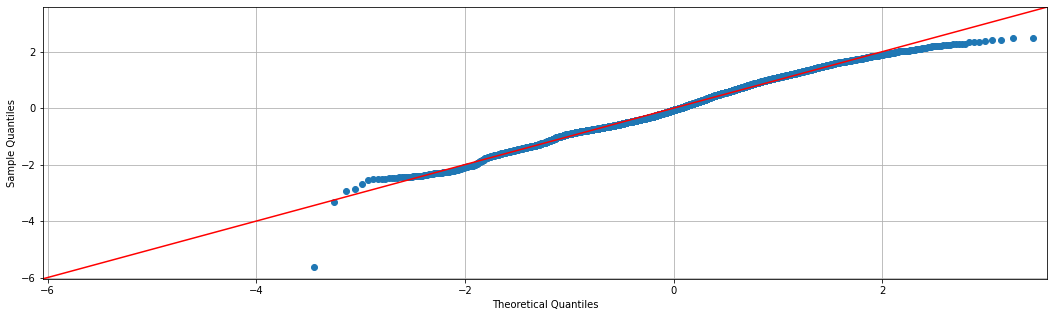

DISCHARGE_PRESSURE  ===>  1.1644469746788162
DISCHARGE_PRESSURE  New (As it is)===>  1.1644469746788162


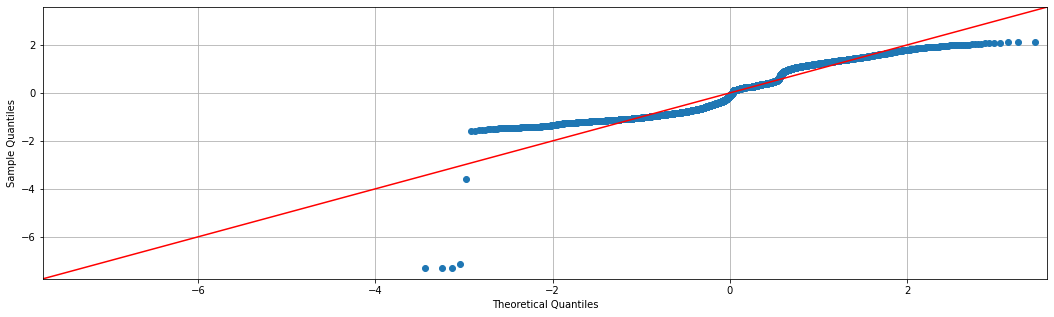

DELTA_PRESSURE  ===>  0.8936403988123326
DELTA_PRESSURE  New New (applying sqrt(input)) ===>  8.472135811722177


RuntimeError: The data contains non-finite values.

In [145]:
# Ensuring that all the columns is normally distributed!
for col in df.columns:
    _, l = stats.boxcox(abs(df[col]))
    print(col , " ===> ", l)
    if (l <= -2):
        tmp_df = 1/np.square(df[col])
        _, l = stats.boxcox(tmp_df)
        print(col , " New (applying 1/square(input)) ===> ", l)
        
    elif (l <= -1 ):
        tmp_df = 1/df[col]
        _, l = stats.boxcox(tmp_df)
        print(col , " New (applying 1/(input)) ===> ", l)
        
    elif (l <= -0.5 ):
        tmp_df = np.sqrt(df[col])
        _, l = stats.boxcox(tmp_df)
        print(col , " New (applying 1/sqrt(input)) ===> ", l)
        
    elif (l <= 0 ):
        tmp_df = 1/np.log(abs(df[col]))
        _, l = stats.boxcox(tmp_df)
        print(col , " New (applying 1/log(input)) ===> ", l)
        
    elif (l >= 2 ):
        tmp_df = np.square(df[col])
        _, l = stats.boxcox(tmp_df)
        print(col , " New (applying square(input)) ===> ", l)
        
    elif (l >= 1 ):
        tmp_df = df[col]
        _, l = stats.boxcox(tmp_df)
        print(col , " New (As it is)===> ", l)
        
    elif (l >= 0.5 ):
        tmp_df = np.sqrt(df[col])
        _, l = stats.boxcox(tmp_df)
        print(col , " New New (applying sqrt(input)) ===> ", l)
    
        
    sm.qqplot(tmp_df, fit=True, line='45')
    plt.show()

In [ ]:
col

In [ ]:
# df['ROD_LOAD_DP'].replace(0,0.001, inplace=True)

In [ ]:
df.columns

In [ ]:
# df['Suction_Flow'].iplot(kind='scatter')

In [ ]:
# df['ROD_LOAD_DP'].isin([-np.inf, np.inf]).sum()

In [ ]:
_, l = stats.boxcox(np.sqrt(np.sqrt(1/np.sqrt(abs(df['DELTA_TEMP_CYLINDER'])))))
l

In [ ]:
df.columns

In [ ]:
# df

### Applying power transform

In [146]:
df_transformed = df.copy()
print("Dataframe shape is  ==> ", df_transformed.shape)


df_transformed['SUCTION_FLOW'] = np.square(df['SUCTION_FLOW'])
df_transformed['SUCTION_PRESSURE'] = np.sqrt(np.log(df['SUCTION_PRESSURE']))
df_transformed['SUCTION_THERMOCOUPLE'] = df['SUCTION_THERMOCOUPLE']
df_transformed['DISCHARGE_CYLINDER_#2'] = np.sqrt(1/np.sqrt(df['DISCHARGE_CYLINDER_#2']))
df_transformed['DISCHARGE_CYLINDER_#4'] = df['DISCHARGE_CYLINDER_#4']
df_transformed['DISCHARGE_PRESSURE'] = df['DISCHARGE_PRESSURE']
df_transformed['PRESSURE_RATIO'] = df['PRESSURE_RATIO']
# df_transformed['STG1_EFF'] = np.sqrt(np.sqrt(1/np.sqrt(abs(df['STG1_EFF']))))

Dataframe shape is  ==>  (3493, 9)


In [147]:
# df_transformed = df.copy()

# Anomaly Score Generation using Clustering Approach

In [148]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [149]:
std_scaler =  MinMaxScaler(clip=True) # StandardScaler() # 
df_scaled = std_scaler.fit_transform(df_transformed.reset_index().drop(['time_stamp'], axis=1))
df_scaled

array([[0.28378043, 0.50351679, 0.15514732, ..., 0.78356295, 0.73683425,
        0.21777534],
       [0.27368342, 0.41329337, 0.14440789, ..., 0.77172046, 0.77510674,
        0.22618152],
       [0.25527688, 0.25495905, 0.13434308, ..., 0.75644062, 0.84936906,
        0.22129259],
       ...,
       [0.2388528 , 0.82919764, 0.61243564, ..., 0.83802423, 0.61796917,
        0.10894042],
       [0.22354935, 0.75910625, 0.76490569, ..., 0.8385145 , 0.65113211,
        0.44239867],
       [0.21819518, 0.73949252, 0.81769971, ..., 0.81119226, 0.6396527 ,
        0.256251  ]])

In [150]:
df_feat = pd.DataFrame(df_scaled, columns=df_transformed.reset_index().drop(['time_stamp'], axis=1).columns)
del df_scaled
df_feat

SUCTION_FLOW  SUCTION_PRESSURE  SUCTION_THERMOCOUPLE  \
0         0.283780          0.503517              0.155147   
1         0.273683          0.413293              0.144408   
2         0.255277          0.254959              0.134343   
3         0.255403          0.266488              0.166726   
4         0.279293          0.474726              0.183262   
...            ...               ...                   ...   
3488      0.242832          0.795476              0.637526   
3489      0.227861          0.740953              0.578140   
3490      0.238853          0.829198              0.612436   
3491      0.223549          0.759106              0.764906   
3492      0.218195          0.739493              0.817700   

      DISCHARGE_CYLINDER_#2  DISCHARGE_CYLINDER_#4  DISCHARGE_PRESSURE  \
0                  0.333263               0.576638            0.744989   
1                  0.334514               0.572625            0.727783   
2                  0.337586               0.570410            0.704224   
3                  0.321514               0.598229            0.706629   
4                  0.322254               0.603636            0.735861   
...                     ...                    ...                 ...   
3488               0.230941               0.815230            0.813518   
3489               0.221985               0.798396            0.799260   
3490               0.218305               0.819447            0.823779   
3491               0.239125               0.891916            0.818236   
3492               0.341236               0.709419            0.789392   

      DELTA_PRESSURE  PRESSURE_RATIO  DELTA_TEMP_CYLINDER  
0           0.783563        0.736834             0.217775  
1           0.771720        0.775107             0.226182  
2           0.756441        0.849369             0.221293  
3           0.758290        0.852490             0.192898  
4           0.776192        0.747881             0.171812  
...              ...             ...                  ...  
3488        0.830701        0.627166             0.150240  
3489        0.820972        0.646376             0.054702  
3490        0.838024        0.617969             0.108940  
3491        0.838514        0.651132             0.442399  
3492        0.811192        0.639653             0.256251  

[3493 rows x 9 columns]

In [151]:
# fig, axs = plt.subplots( int(len(df_feat.columns)/2)+1, 2,figsize=(20,22))
# fig.suptitle('Multiple distribution plots with MIN-MAX SCALING')

# col_num = 0
# for i in range(axs.shape[0]):
#     for j in range(axs.shape[1]):
#         if col_num >= len(df_feat.columns):
#             break
        
#         temp = df_feat.iloc[:, col_num]
#         sns.kdeplot(temp, ax=axs[i, j])
#         #axs[i, j].hist(temp,bins=100)
#         #axs[i, j].plot(temp)
#         per = np.percentile(temp, 50)
#         axs[i, j].axvline(per, alpha = 0.6, ymax = 0.80, linestyle = ":", color='red',lw=4)
#         #axs[i, j].set_xticklabels(temp.eucl_dist_3_norm_cc,fontsize=20)
        
#         del temp # Clearing memory
#         axs[i,j].set_title(str(df_feat.columns[col_num]), fontsize=20) 
#         col_num = col_num + 1
# fig.tight_layout()
# plt.xticks(fontsize=20)
# plt.show()
# plt.clf()

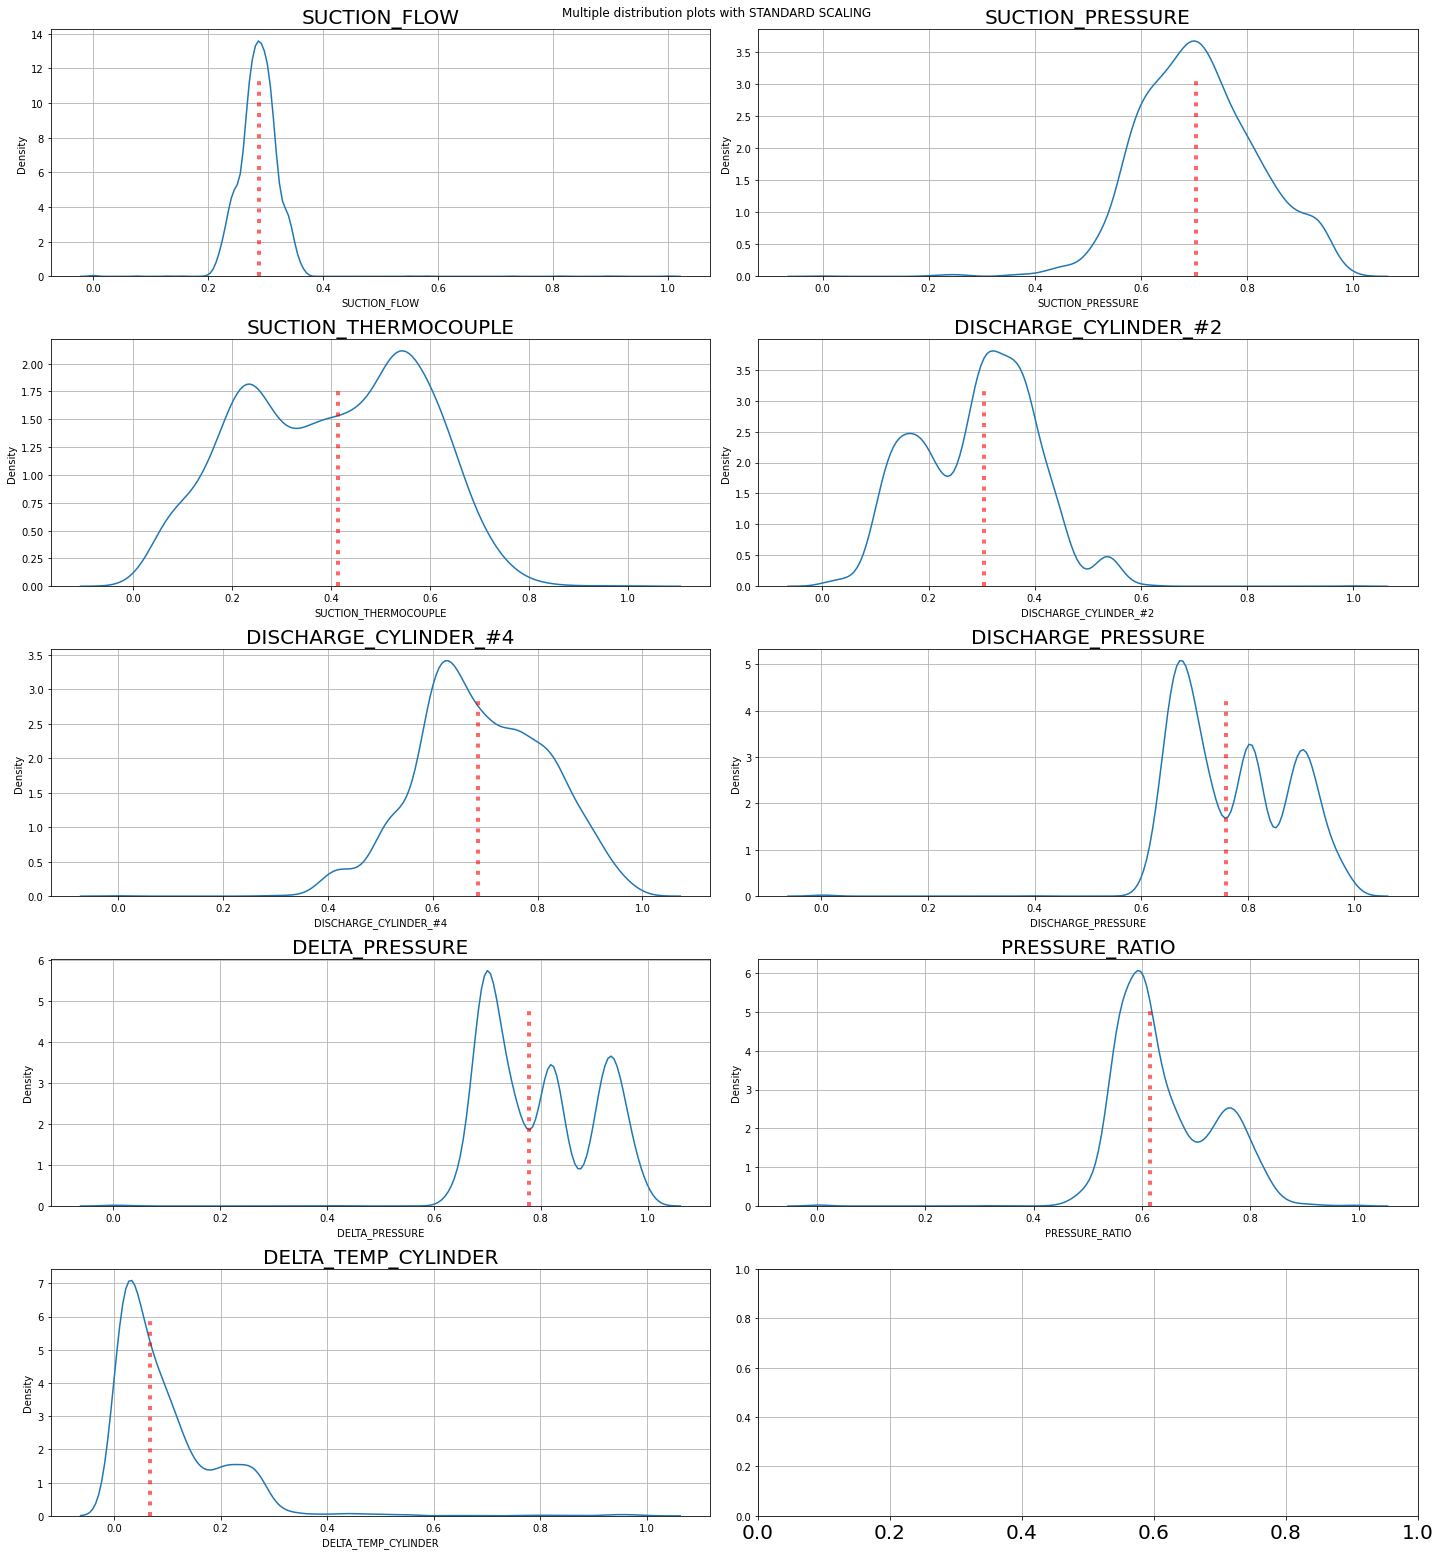

<Figure size 1296x360 with 0 Axes>

In [152]:
fig, axs = plt.subplots( int(len(df_feat.columns)/2)+1, 2,figsize=(20,22))
fig.suptitle('Multiple distribution plots with STANDARD SCALING')

col_num = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        if col_num >= len(df_feat.columns):
            break
        
        temp = df_feat.iloc[:, col_num]
        sns.kdeplot(temp, ax=axs[i, j])
        #axs[i, j].hist(temp,bins=100)
        #axs[i, j].plot(temp)
        per = np.percentile(temp, 50)
        axs[i, j].axvline(per, alpha = 0.6, ymax = 0.80, linestyle = ":", color='red',lw=4)
        #axs[i, j].set_xticklabels(temp.eucl_dist_3_norm_cc,fontsize=20)
        
        del temp # Clearing memory
        axs[i,j].set_title(str(df_feat.columns[col_num]), fontsize=20) 
        col_num = col_num + 1
fig.tight_layout()
plt.xticks(fontsize=20)
plt.show()
plt.clf()

In [153]:
df_feat.describe().T

count      mean       std  min       25%       50%  \
SUCTION_FLOW           3493.0  0.288289  0.037474  0.0  0.269539  0.288514   
SUCTION_PRESSURE       3493.0  0.710266  0.111406  0.0  0.632021  0.703788   
SUCTION_THERMOCOUPLE   3493.0  0.402527  0.179744  0.0  0.247070  0.415283   
DISCHARGE_CYLINDER_#2  3493.0  0.291357  0.110281  0.0  0.196801  0.304692   
DISCHARGE_CYLINDER_#4  3493.0  0.693024  0.122954  0.0  0.608635  0.685762   
DISCHARGE_PRESSURE     3493.0  0.773554  0.106258  0.0  0.680357  0.759852   
DELTA_PRESSURE         3493.0  0.797105  0.104101  0.0  0.704624  0.777894   
PRESSURE_RATIO         3493.0  0.642955  0.090942  0.0  0.575657  0.615163   
DELTA_TEMP_CYLINDER    3493.0  0.101109  0.107487  0.0  0.029428  0.068239   

                            75%  max  
SUCTION_FLOW           0.307096  1.0  
SUCTION_PRESSURE       0.782136  1.0  
SUCTION_THERMOCOUPLE   0.551204  1.0  
DISCHARGE_CYLINDER_#2  0.370116  1.0  
DISCHARGE_CYLINDER_#4  0.785578  1.0  
DISCHARGE_PRESSURE     0.877891  1.0  
DELTA_PRESSURE         0.909466  1.0  
PRESSURE_RATIO         0.715250  1.0  
DELTA_TEMP_CYLINDER    0.137648  1.0

#### Dropping 2 disch temp cyl columns

In [154]:
# try:
#     df_feat.drop(['Stg3DischTempCyl2A', 'Stg3DischTempCyl2B'], axis=1, inplace=True)
# except:
#     print("Nothing to delete")

In [155]:
df_feat.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER'],
      dtype='object')

In [156]:
%%time

k_rng = np.arange(1,10)
wcss = []
for k in range(1,10):
    km = KMeans(n_clusters=k)
    km.fit(df_feat)
    wcss.append(km.inertia_)

Wall time: 927 ms


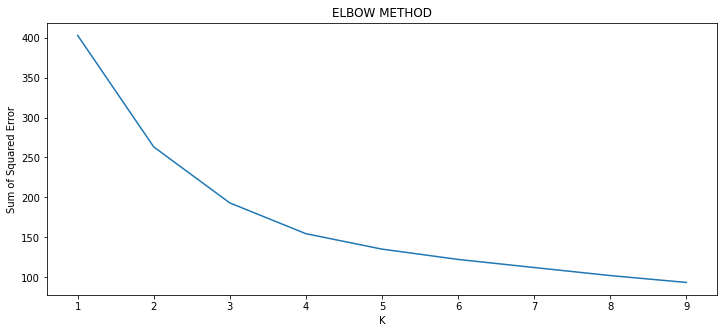

In [157]:
plt.figure(figsize=(12,5))
plt.xlabel('K')
plt.ylabel('Sum of Squared Error')
plt.plot(k_rng, wcss)
plt.title('ELBOW METHOD')
plt.grid()
plt.show()

In [158]:
df_cluster = pd.DataFrame()

for i in range(3,10):
    km = KMeans(n_clusters=i, random_state=101)
    
    try:
        # del df_feat[['Cluster_distance', 'Variance', 'Cluster_weight', 'Final_Score']]
        df_feat.drop(['clusters'], axis=1, inplace=True)
        #df_feat.drop(['Cluster_distance', 'Variance', 'Cluster_weight', 'Final_Score'], axis=1, inplace=True)
    except:
        pass
        # print("No columns to delete!!")
    
    # Doing the predictions from K-Means model
    y_predicted = km.fit_predict(df_feat)
    df_feat['clusters'] = y_predicted
    
    df_cluster = pd.concat([df_cluster, 
                            df_feat['clusters'].value_counts().reset_index(name='n='+str(i))], axis=1)
    df_cluster.rename(columns={'index': 'index_'+str(i)}, inplace=True)
    
    print("Completed for cluster => ", i)
    

Completed for cluster =>  3
Completed for cluster =>  4
Completed for cluster =>  5
Completed for cluster =>  6
Completed for cluster =>  7
Completed for cluster =>  8
Completed for cluster =>  9


In [159]:
df_cluster

index_3     n=3  index_4     n=4  index_5    n=5  index_6    n=6  index_7  \
0      1.0  1251.0      3.0  1137.0      1.0  905.0      1.0  846.0      6.0   
1      2.0  1227.0      1.0  1136.0      2.0  892.0      2.0  824.0      2.0   
2      0.0  1015.0      2.0   693.0      3.0  674.0      4.0  573.0      1.0   
3      NaN     NaN      0.0   527.0      4.0  517.0      3.0  513.0      5.0   
4      NaN     NaN      NaN     NaN      0.0  505.0      5.0  456.0      4.0   
5      NaN     NaN      NaN     NaN      NaN    NaN      0.0  281.0      3.0   
6      NaN     NaN      NaN     NaN      NaN    NaN      NaN    NaN      0.0   
7      NaN     NaN      NaN     NaN      NaN    NaN      NaN    NaN      NaN   
8      NaN     NaN      NaN     NaN      NaN    NaN      NaN    NaN      NaN   

     n=7  index_8    n=8  index_9  n=9  
0  765.0      2.0  766.0        1  764  
1  573.0      1.0  566.0        8  566  
2  556.0      4.0  553.0        4  445  
3  505.0      3.0  480.0        2  425  
4  432.0      7.0  427.0        3  383  
5  387.0      0.0  385.0        0  354  
6  275.0      6.0  281.0        7  268  
7    NaN      5.0   35.0        6  256  
8    NaN      NaN    NaN        5   32

In [160]:
df_feat.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER', 'clusters'],
      dtype='object')

### Choose a final K value from the above dataframe

In [161]:
k_value = 9

km = KMeans(n_clusters=k_value, random_state=101)
km

KMeans(n_clusters=9, random_state=101)

In [162]:
df_feat.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER', 'clusters'],
      dtype='object')

In [163]:
try:
    df_feat.drop(['clusters'], axis=1, inplace=True)
    print('deleted clusters column!!')
    # del df_feat[['Cluster_distance', 'Variance', 'Cluster_weight', 'Final_Score']]
    # df_feat.drop(['Cluster_distance', 'Variance', 'Cluster_weight', 'Final_Score'], axis=1, inplace=True)
except:
    print("No columns!!")

deleted clusters column!!


In [164]:
df_feat.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER'],
      dtype='object')

In [165]:
%%time
print("Training the Clustering model with k = {} \n \n".format(k_value))
y_predicted = km.fit_predict(df_feat)
df_feat['clusters'] = y_predicted

Training the Clustering model with k = 9 
 

Wall time: 184 ms


In [166]:
df_feat['clusters'].value_counts()  # 9

1    764
8    566
4    445
2    425
3    383
0    354
7    268
6    256
5     32
Name: clusters, dtype: int64

### Going with k=9 clusters

In [167]:
df_feat

SUCTION_FLOW  SUCTION_PRESSURE  SUCTION_THERMOCOUPLE  \
0         0.283780          0.503517              0.155147   
1         0.273683          0.413293              0.144408   
2         0.255277          0.254959              0.134343   
3         0.255403          0.266488              0.166726   
4         0.279293          0.474726              0.183262   
...            ...               ...                   ...   
3488      0.242832          0.795476              0.637526   
3489      0.227861          0.740953              0.578140   
3490      0.238853          0.829198              0.612436   
3491      0.223549          0.759106              0.764906   
3492      0.218195          0.739493              0.817700   

      DISCHARGE_CYLINDER_#2  DISCHARGE_CYLINDER_#4  DISCHARGE_PRESSURE  \
0                  0.333263               0.576638            0.744989   
1                  0.334514               0.572625            0.727783   
2                  0.337586               0.570410            0.704224   
3                  0.321514               0.598229            0.706629   
4                  0.322254               0.603636            0.735861   
...                     ...                    ...                 ...   
3488               0.230941               0.815230            0.813518   
3489               0.221985               0.798396            0.799260   
3490               0.218305               0.819447            0.823779   
3491               0.239125               0.891916            0.818236   
3492               0.341236               0.709419            0.789392   

      DELTA_PRESSURE  PRESSURE_RATIO  DELTA_TEMP_CYLINDER  clusters  
0           0.783563        0.736834             0.217775         8  
1           0.771720        0.775107             0.226182         8  
2           0.756441        0.849369             0.221293         0  
3           0.758290        0.852490             0.192898         0  
4           0.776192        0.747881             0.171812         8  
...              ...             ...                  ...       ...  
3488        0.830701        0.627166             0.150240         7  
3489        0.820972        0.646376             0.054702         7  
3490        0.838024        0.617969             0.108940         7  
3491        0.838514        0.651132             0.442399         7  
3492        0.811192        0.639653             0.256251         7  

[3493 rows x 10 columns]

# Visualizing the clusters

In [168]:
df_feat['clusters'].value_counts()  # 9

1    764
8    566
4    445
2    425
3    383
0    354
7    268
6    256
5     32
Name: clusters, dtype: int64

In [169]:
df_feat.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER', 'clusters'],
      dtype='object')

In [170]:
# %%time

# cols = ['Suction_Pressure', 'Suction_Temperature', 'Discharge_Pressure']
# pp = sns.pairplot(df_feat[cols + ['clusters']], 
#                   hue='clusters', height=1.8, aspect=1.8, palette='bright',
#                   plot_kws=dict(edgecolor="black", linewidth=0.5))
# fig = pp.fig 
# fig.set_size_inches(15,10)
# fig.subplots_adjust(top=0.93, wspace=0.3)
# t = fig.suptitle(str(cols) + ' power transform + min max', fontsize=16)

In [171]:
df.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER'],
      dtype='object')

Wall time: 3.11 s


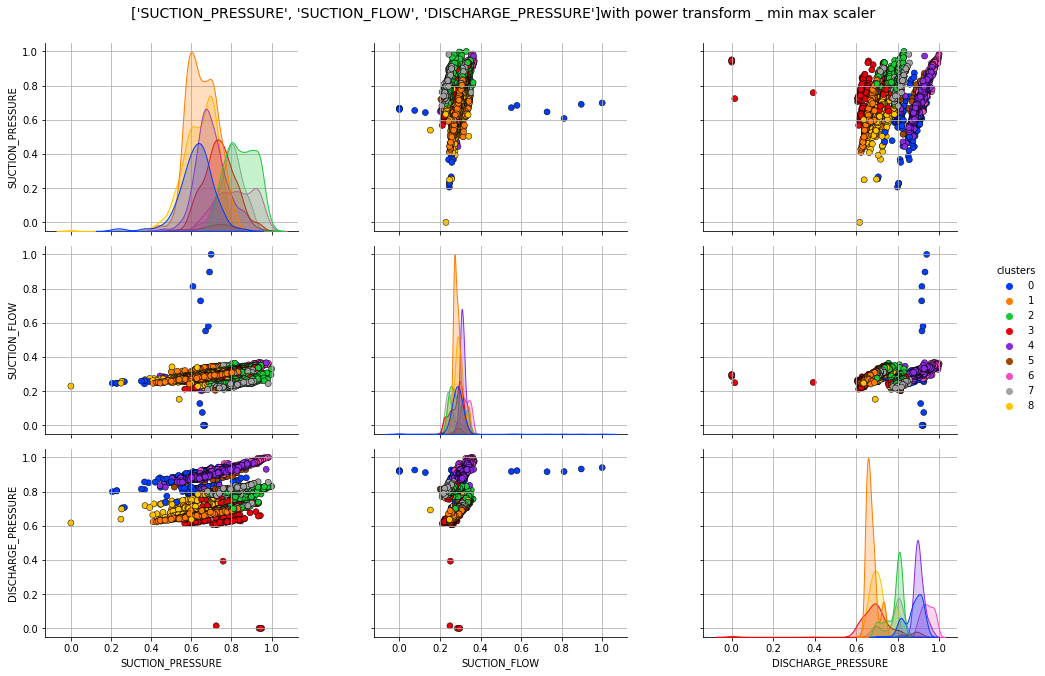

In [172]:
%%time

cols = ['SUCTION_PRESSURE', 'SUCTION_FLOW', 'DISCHARGE_PRESSURE']
pp = sns.pairplot(df_feat[cols + ['clusters']], 
                  hue='clusters', height=1.8, aspect=1.8, palette='bright',
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.set_size_inches(15,10)
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle(str(cols) + 'with power transform _ min max scaler', fontsize=14)

In [173]:
# %%time

# cols = ['Discharge_Temperature', 'Delta_Temperature', 'Delta_Pressure', 'Pressure_ratio']
# pp = sns.pairplot(df_feat[cols + ['clusters']], 
#                   hue='clusters', height=1.8, aspect=1.8, palette='bright',
#                   plot_kws=dict(edgecolor="black", linewidth=0.5))
# fig = pp.fig 
# fig.set_size_inches(15,10)
# fig.subplots_adjust(top=0.93, wspace=0.3)
# t = fig.suptitle(str(cols) + ' power transform + min max', fontsize=16)

In [174]:
df_feat['clusters'].value_counts()  # 8

1    764
8    566
4    445
2    425
3    383
0    354
7    268
6    256
5     32
Name: clusters, dtype: int64

# Valve Failures C33100

    C33100 1ST STAGE CYLINDER 4 VALVES         17 May 2021 - 21 May 2021
    
                

In [175]:
# Putting back the cluster labels to the original dataframe
print("Putting back the cluster labels to the original dataframe! \n")
df['clusters'] = df_feat['clusters'].values

Putting back the cluster labels to the original dataframe! 



In [176]:
# del df['clusters']

In [177]:
df_feat['clusters'].value_counts()

1    764
8    566
4    445
2    425
3    383
0    354
7    268
6    256
5     32
Name: clusters, dtype: int64

In [178]:
# fig, ax = plt.subplots(1, 1, figsize=(25,8))
# yy = 3  # Cluster to visualize
# # df_filtered.plot(ax=ax, y=usecols, figsize=(30,12))
# ax2 = ax.twinx()
# ax2.plot(df_2.index, df_feat['clusters'].apply(lambda x:x==yy), 'r')
# plt.title('CLUSTER  '+ str(yy))
# plt.grid()

In [179]:
df['clusters'].value_counts()

1    764
8    566
4    445
2    425
3    383
0    354
7    268
6    256
5     32
Name: clusters, dtype: int64

In [180]:
# df['clusters'].iplot(title='Clusters Visualization k = {} (powertransform + sTANDARD scaler)'.format(k_value))

# Anomaly Scoring

## Component 1 = Cluster Distance
    How much distance a single datapoint is having from its own cluster

In [181]:
# df_feat.drop(['Cluster_distance', 'Variance', 'Cluster_weight', 'Final_Score'], axis=1, inplace=True)

In [182]:
try:
    df_feat.drop(['Cluster_distance'], axis=1, inplace=True)
    print("Deleted the cluster distance column!")
except:
    print('No columns to delete!')

No columns to delete!


In [183]:
alldistances = km.fit_transform(df_feat.drop('clusters', axis=1))  # .drop('clusters', axis=1)
df_feat['Cluster_distance']=np.mean(alldistances, axis=1) # we take min when doing standard scaler & max when doing min_max scaling

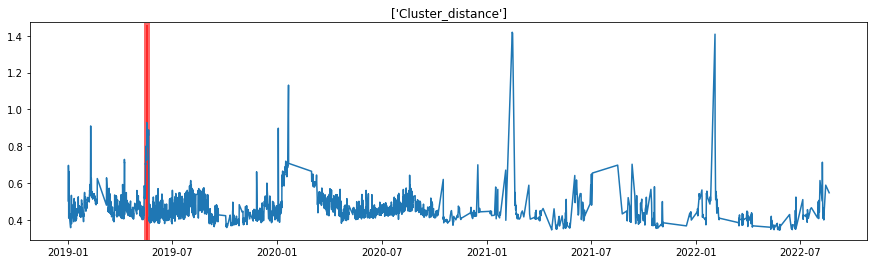

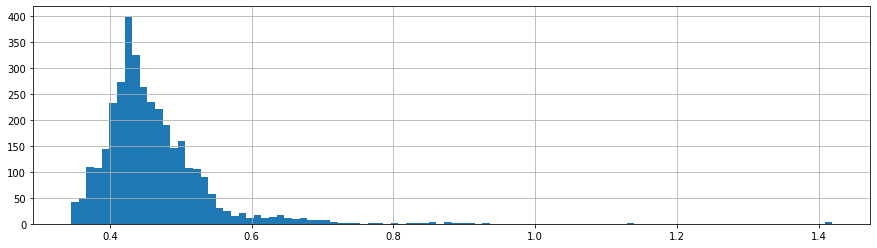

In [184]:
fig, ax = plt.subplots(1,1,figsize = (15,4))
ax.plot(df.index, df_feat.loc[:,'Cluster_distance'])
ax.axvspan(START_DATE_1, END_DATE_1, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)
# ax.axvspan(START_DATE_2, END_DATE_2, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)

ax.grid()
ax.title.set_text(['Cluster_distance'])
plt.show()

plt.figure(figsize=(15,4))
plt.hist(df_feat.loc[:,'Cluster_distance'],bins=100)
plt.ticklabel_format(useOffset=False)
plt.show()

In [185]:
# temp = df_feat.loc[:,'Cluster_distance']
# temp.index = df_2.index
# temp.ewm(alpha=0.01).mean().iplot(title='Cluster Distance (power transform + min max scaling)')

In [186]:
START_DATE_1, END_DATE_1

(datetime.datetime(2019, 5, 17, 0, 0), datetime.datetime(2019, 5, 21, 0, 0))

In [187]:
temp = df_feat.loc[:,'Cluster_distance']
temp.index = df.index

fig = temp.ewm(alpha=0.1).mean().iplot(title='Cluster Distance trends.....', asFigure=True)
fig.layout.legend.orientation = 'h'
fig.layout.xaxis.title = 'Date time'
fig.layout.yaxis.title = 'Valve Data'
fig.add_vrect(x0=START_DATE_1, x1=END_DATE_1, annotation_text='FAILURE', annotation_position="top left",
              fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_2, x1=END_DATE_2, annotation_text='FAILURE', annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)

## Component 2 = Variance 
    How much a single data point is varying from the overall distribution of the data

In [188]:
try :
    df_feat.drop('Variance', axis=1, inplace=True)
    print('deleted variance column!!')
except:
    print('No columns to delete')

No columns to delete


In [189]:
df_feat['Variance'] = np.max(df_feat.drop(['Cluster_distance', 'clusters'], axis=1).to_numpy() - np.median(df_feat.drop(['Cluster_distance', 'clusters'], axis=1), axis=0), axis=1)

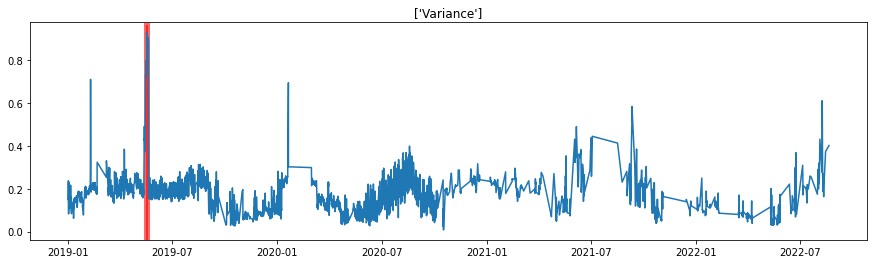

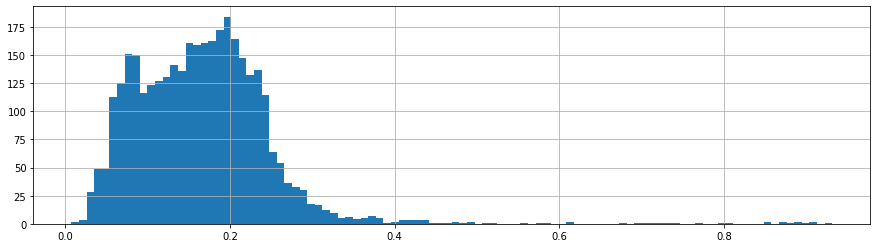

In [190]:
fig, ax = plt.subplots(1,1,figsize = (15,4))
ax.plot(df.index, df_feat.loc[:,'Variance'])
ax.axvspan(START_DATE_1, END_DATE_1, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)
# ax.axvspan(START_DATE_2, END_DATE_2, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)

ax.grid()
ax.title.set_text(['Variance'])
plt.show()

plt.figure(figsize=(15,4))
plt.hist(df_feat.loc[:,'Variance'],bins=100)
plt.ticklabel_format(useOffset=False)
plt.show()

In [191]:
# temp = df_feat.loc[:,'Variance']
# temp.index = df_2.index
# temp.iplot(title='Cluster Variance (power transform + min max scaling)')

In [192]:
# temp.ewm(alpha=0.01).mean().iplot(title='Cluster Variance (power transform + min max scaling)')

In [193]:
temp = df_feat.loc[:,'Variance']
temp.index = df.index

fig = temp.ewm(alpha=0.01).mean().iplot(title='Cluster Variance trends.....', asFigure=True)
fig.layout.legend.orientation = 'h'
fig.layout.xaxis.title = 'Date time'
fig.layout.yaxis.title = 'Valve Data'
fig.add_vrect(x0=START_DATE_1, x1=END_DATE_1, annotation_text='FAILURE', annotation_position="top left",
              fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_2, x1=END_DATE_2, annotation_text='FAILURE', annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)

In [194]:
# (temp.ewm(alpha=0.02).mean()).iplot(title='Cluster Variance (power transform + MIN MAX scaling)')

In [195]:
# temp.ewm(alpha=0.01).mean().iplot(title='Cluster Variance (power transform + standard scaling)')

In [196]:
df_feat['clusters'].value_counts()

1    764
8    566
4    445
2    425
3    383
0    354
7    268
6    256
5     32
Name: clusters, dtype: int64

In [197]:
df_feat.shape[0]

3493

In [198]:
df_feat.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER', 'clusters',
       'Cluster_distance', 'Variance'],
      dtype='object')

## Component 3 = Cluster weights
    Here we decide how much weight to give to each cluster

In [199]:
cluster_weights = {}
for i,j in zip(df_feat['clusters'].value_counts().index, df_feat['clusters'].value_counts()):
    # print(i, j)
    cluster_weights[i] = j/df_feat.shape[0]
    
cluster_weights

{1: 0.21872316060692815,
 8: 0.16203836243916403,
 4: 0.12739765244775264,
 2: 0.1216719152590896,
 3: 0.10964786716289722,
 0: 0.10134554823933581,
 7: 0.07672487832808474,
 6: 0.07328943601488691,
 5: 0.009161179501860864}

In [200]:
# For Custom weights
cluster_weights = {1: 0.21872316060692815,
                 8: 0,
                 4: 0.12739765244775264,
                 2: 0.1216719152590896,
                 3: 0.10964786716289722,
                 0: 0.10134554823933581,
                 7: 0.07672487832808474,
                 6: 0.07328943601488691,
                 5: 0.009161179501860864
                }

df_feat['Cluster_weight'] = 0
for key, value in cluster_weights.items():
    print("Cluster ==> {} and Weight ==> {} ".format(key, value))
    df_feat['Cluster_weight'] = np.where(df_feat['clusters']==key, value, df_feat['Cluster_weight'])

Cluster ==> 1 and Weight ==> 0.21872316060692815 
Cluster ==> 8 and Weight ==> 0 
Cluster ==> 4 and Weight ==> 0.12739765244775264 
Cluster ==> 2 and Weight ==> 0.1216719152590896 
Cluster ==> 3 and Weight ==> 0.10964786716289722 
Cluster ==> 0 and Weight ==> 0.10134554823933581 
Cluster ==> 7 and Weight ==> 0.07672487832808474 
Cluster ==> 6 and Weight ==> 0.07328943601488691 
Cluster ==> 5 and Weight ==> 0.009161179501860864 


### Scaling of the 3 Scoring components (component 1, 2, 3)

In [201]:
sca1=MinMaxScaler(clip=True)
df_feat[['Cluster_distance','Variance','Cluster_weight']]=sca1.fit_transform(df_feat[['Cluster_distance','Variance','Cluster_weight']])

### Giving weight to 3 components as per data behaviour

In [202]:
df_feat['Final_Score'] = df_feat['Cluster_distance']*.35 + df_feat['Variance']*.55 + df_feat['Cluster_weight']*0.10

## Over all 3 components visualization

In [203]:
START_DATE_1 = datetime(2019, 5, 17)  # year, month, date
END_DATE_1 = datetime(2019, 5, 21)    # year, month, date

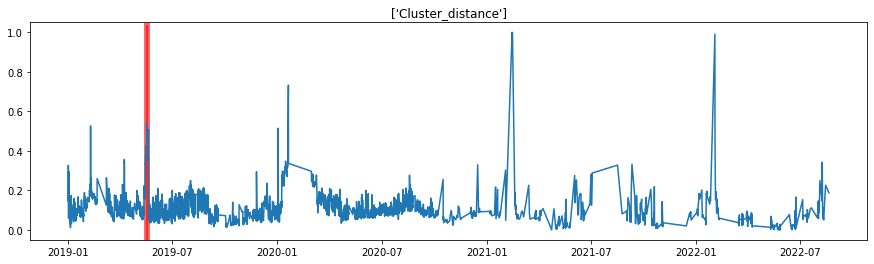

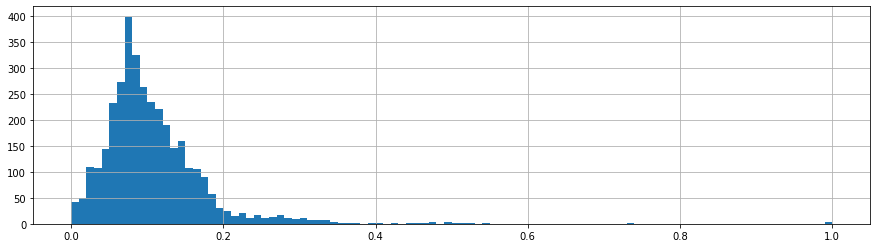

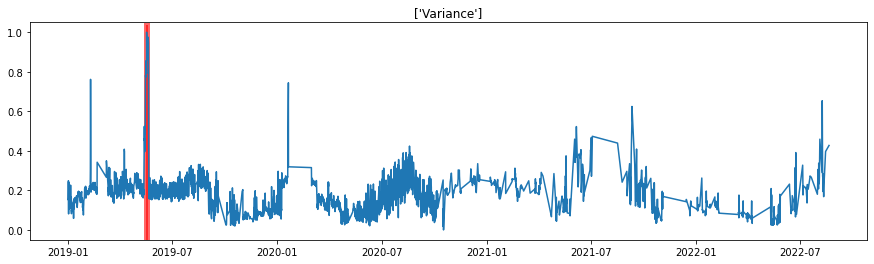

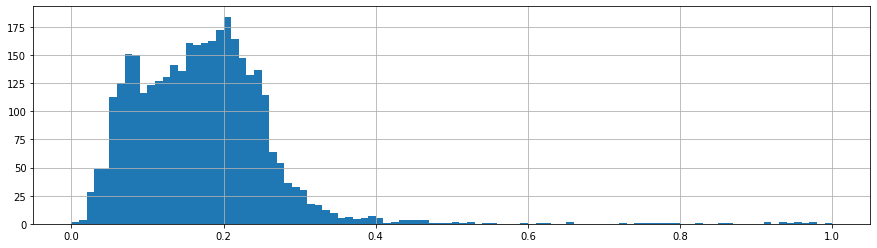

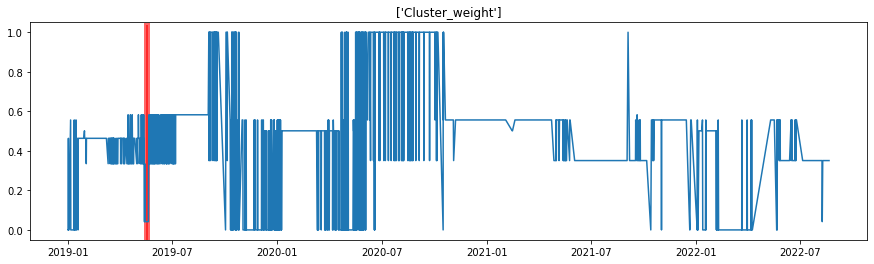

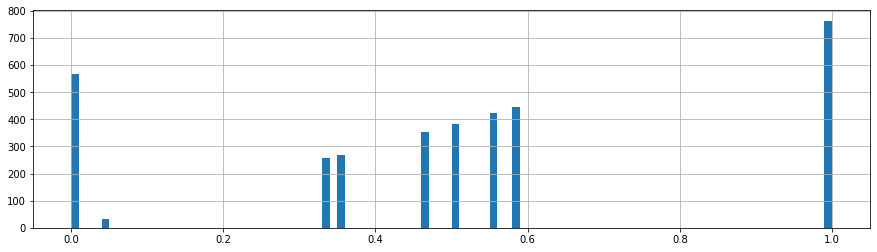

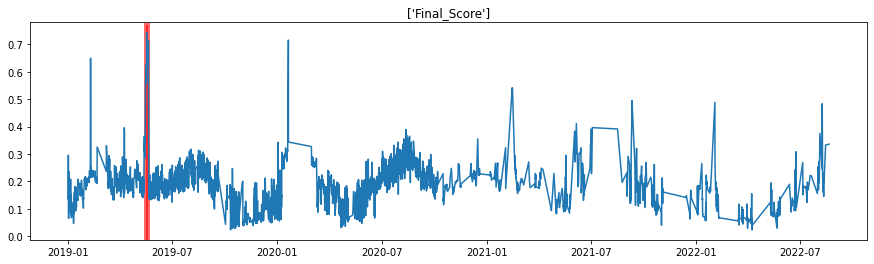

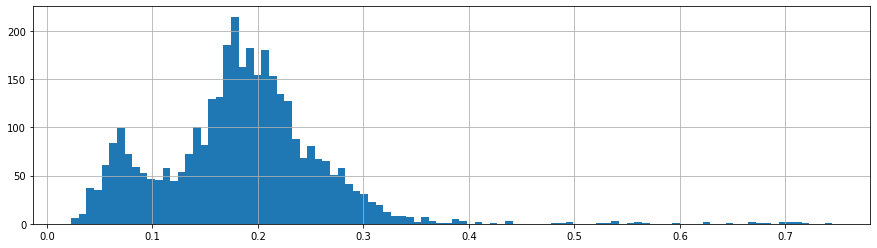

In [204]:
for i in ['Cluster_distance','Variance','Cluster_weight','Final_Score']:
    fig, ax = plt.subplots(1,1,figsize = (15,4))
    ax.plot(df.index, df_feat.loc[:,i])
    ax.get_frame_on()
    ax.axvspan(START_DATE_1, END_DATE_1, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)
#     ax.axvspan(START_DATE_2, END_DATE_2, alpha = 0.6, ymax = 0.99, linestyle = "-", color='red',lw=4)
    ax.grid()
    ax.title.set_text([i])
    plt.show()
    plt.figure(figsize=(15,4))
    plt.hist(df_feat.loc[:,i], bins=100)
    plt.ticklabel_format(useOffset=False)
    plt.show()

In [205]:
df['clusters'].iplot()

In [206]:
# temp = df_feat.loc[:,'Final_Score']
# temp.index = df.index
# temp.iplot(title='Final Score with power transform + min max scaler')

In [207]:
# START_DATE_2, END_DATE_2

In [208]:
SMOOTH_FACTOR = 0.2

temp = df_feat.loc[:,'Final_Score']
temp.index = df.index

fig = temp.ewm(alpha=SMOOTH_FACTOR).mean().iplot(title='Final_Score trends.....', asFigure=True)
fig.layout.legend.orientation = 'h'
fig.layout.xaxis.title = 'Date time'
fig.layout.yaxis.title = 'Valve Data'
fig.add_vrect(x0=START_DATE_1, x1=END_DATE_1, annotation_text='FAILURE', annotation_position="top left",
              fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_2, x1=END_DATE_2, annotation_text='FAILURE', annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)

In [209]:
# temp.ewm(alpha=0.01).mean().iplot(title='EWM of Final Score with power transform + min max scaler')

# Std SCALER

In [210]:
# temp = df_feat.loc[:,'Final_Score']
# temp.index = df.index
# temp.iplot(title='Final Score with power transform + min max scaler')

In [211]:
# temp.ewm(alpha=0.05).mean().iplot(title='EWM of Final Score with power transform + min max scaler')

### Attaching the smoothened ewm to original dataframe

In [212]:
# df['Anomaly_Scores'] = temp.ewm(alpha=0.01).mean()

### Scaling between 0-0.7

In [213]:
SCALING_RANGE = (0, 0.80)
SMOOTH_FACTOR = 0.2 # (Ranges b/w 0-1)



final_scale = MinMaxScaler(feature_range=SCALING_RANGE, clip=True)
df['Anomaly_Scores'] = pd.DataFrame(final_scale.fit_transform(temp.ewm(alpha=SMOOTH_FACTOR).mean().values.reshape(-1,1)), index=df.index)

In [214]:
df.columns

Index(['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
       'DISCHARGE_CYLINDER_#2', 'DISCHARGE_CYLINDER_#4', 'DISCHARGE_PRESSURE',
       'DELTA_PRESSURE', 'PRESSURE_RATIO', 'DELTA_TEMP_CYLINDER', 'clusters',
       'Anomaly_Scores'],
      dtype='object')

In [215]:
%%time

# FAILURES
TITLE_1 = "Stg-3 Valve failures C35100"
START_DATE_1 = datetime(2019, 5, 17)  # year, month, date
END_DATE_1 = datetime(2019, 5, 21)    # year, month, date

TITLE_2 = "Stg-3 Valve failures C35100"
START_DATE_2 = datetime(2019, 4, 19)  # year, month, date
END_DATE_2 = datetime(2019, 4, 23)    # year, month, date

TITLE_3 = "Stg-1 Valve failures C35100"
START_DATE_3 = datetime(2021, 9, 22)
END_DATE_3 = datetime(2021, 10, 6)

TITLE_4 = "Stg-2 Valve failures C35100"
START_DATE_4 = datetime(2020, 3, 30)
END_DATE_4 = datetime(2020, 5, 15)

TITLE_5 = "PLANNED OVERHAUL"
START_DATE_5 = datetime(2020, 7, 20)
END_DATE_5 = datetime(2020, 8, 13)


fig = df.iplot(y=['Anomaly_Scores'], secondary_y=['SUCTION_FLOW', 'SUCTION_PRESSURE', 'SUCTION_THERMOCOUPLE',
                                                  'DELTA_TEMP_CYLINDER', 'DISCHARGE_PRESSURE',
       'PRESSURE_RATIO'], asFigure=True)
fig.layout.legend.orientation = 'h'
fig.layout.xaxis.title = 'Date time'
fig.layout.yaxis.title = 'Valve Data'
fig.add_vrect(x0=START_DATE_1, x1=END_DATE_1, annotation_text=TITLE_1, annotation_position="top left",
              fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_2, x1=END_DATE_2, annotation_text=TITLE_2, annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_3, x1=END_DATE_3, annotation_text=TITLE_3, annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_4, x1=END_DATE_4, annotation_text=TITLE_4, annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_5, x1=END_DATE_5, annotation_text=TITLE_5, annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)

cf.iplot(fig)

Wall time: 6.35 s


In [228]:
df

SUCTION_FLOW  SUCTION_PRESSURE  SUCTION_THERMOCOUPLE  \
time_stamp                                                                  
2019-01-01 04:00:00      8.814003          5.194933             35.289555   
2019-01-01 08:00:00      8.655781          4.830067             34.667764   
2019-01-01 12:00:00      8.359643          4.267552             34.085032   
2019-01-01 16:00:00      8.361713          4.305464             35.959932   
2019-01-01 20:00:00      8.744045          5.074695             36.917346   
...                           ...               ...                   ...   
2022-08-11 00:00:00      8.153333          6.650000             63.218333   
2022-08-11 12:00:00      7.898000          6.342000             59.780000   
2022-08-11 16:00:00      8.086250          6.850000             61.765625   
2022-08-14 20:00:00      7.822917          6.442500             70.593333   
2022-08-20 20:00:00      7.728667          6.334000             73.650000   

                     DISCHARGE_CYLINDER_#2  DISCHARGE_CYLINDER_#4  \
time_stamp                                                          
2019-01-01 04:00:00             192.875322             186.063029   
2019-01-01 08:00:00             192.719074             185.645106   
2019-01-01 12:00:00             192.336219             185.414438   
2019-01-01 16:00:00             194.349793             188.311890   
2019-01-01 20:00:00             194.256512             188.875008   
...                                    ...                    ...   
2022-08-11 00:00:00             206.203333             210.913333   
2022-08-11 12:00:00             207.424000             209.160000   
2022-08-11 16:00:00             207.928125             211.352500   
2022-08-14 20:00:00             205.095833             218.900417   
2022-08-20 20:00:00             191.882667             199.892667   

                     DISCHARGE_PRESSURE  DELTA_PRESSURE  PRESSURE_RATIO  \
time_stamp                                                                
2019-01-01 04:00:00           50.333333       45.138401        9.712325   
2019-01-01 08:00:00           49.170833       44.340766       10.216795   
2019-01-01 12:00:00           47.579167       43.311615       11.195648   
2019-01-01 16:00:00           47.741667       43.436203       11.236782   
2019-01-01 20:00:00           49.716667       44.641972        9.857936   
...                                 ...             ...             ...   
2022-08-11 00:00:00           54.963333       48.313333        8.266781   
2022-08-11 12:00:00           54.000000       47.658000        8.519989   
2022-08-11 16:00:00           55.656562       48.806562        8.145562   
2022-08-14 20:00:00           55.282083       48.839583        8.582683   
2022-08-20 20:00:00           53.333333       46.999333        8.431373   

                     DELTA_TEMP_CYLINDER  clusters  Anomaly_Scores  
time_stamp                                                          
2019-01-01 04:00:00             6.812293         8        0.107098  
2019-01-01 08:00:00             7.073968         8        0.126089  
2019-01-01 12:00:00             6.921781         0        0.200743  
2019-01-01 16:00:00             6.037903         0        0.234193  
2019-01-01 20:00:00             5.381505         8        0.191956  
...                                  ...       ...             ...  
2022-08-11 00:00:00             4.710000         7        0.210874  
2022-08-11 12:00:00             1.736000         7        0.192461  
2022-08-11 16:00:00             3.424375         7        0.184539  
2022-08-14 20:00:00            13.804583         7        0.218599  
2022-08-20 20:00:00             8.010000         7        0.246689  

[3493 rows x 11 columns]

In [216]:
# %%time

# # FAILURES
# TITLE_1 = "Stg-3 Valve failures C35100"
# START_DATE_1 = datetime(2021, 4, 19)  # year, month, date
# END_DATE_1 = datetime(2021, 4, 23)    # year, month, date

# TITLE_2 = "Stg-3 Valve failures C35100"
# START_DATE_2 = datetime(2019, 4, 19)  # year, month, date
# END_DATE_2 = datetime(2019, 4, 23)    # year, month, date

# TITLE_3 = "Stg-1 Valve failures C35100"
# START_DATE_3 = datetime(2021, 9, 22)
# END_DATE_3 = datetime(2021, 10, 6)

# TITLE_4 = "Stg-2 Valve failures C35100"
# START_DATE_4 = datetime(2020, 3, 30)
# END_DATE_4 = datetime(2020, 5, 15)

# TITLE_5 = "PLANNED OVERHAUL"
# START_DATE_5 = datetime(2020, 7, 20)
# END_DATE_5 = datetime(2020, 8, 13)


# fig = df.iplot(y=['Anomaly_Scores'], secondary_y=['Suction_Pressure','Discharge_Temperature', 'Discharge_Cooler_Outlet_Temp'], asFigure=True)
# fig.layout.legend.orientation = 'h'
# fig.layout.xaxis.title = 'Date time'
# fig.layout.yaxis.title = 'Valve Data'
# # fig.add_vrect(x0=START_DATE_1, x1=END_DATE_1, annotation_text=TITLE_1, annotation_position="top left",
# #               fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_2, x1=END_DATE_2, annotation_text=TITLE_2, annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_3, x1=END_DATE_3, annotation_text=TITLE_3, annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)
# fig.add_vrect(x0=START_DATE_4, x1=END_DATE_4, annotation_text=TITLE_4, annotation_position="top left",
#               fillcolor="red", opacity=0.5, line_width=1)
# # fig.add_vrect(x0=START_DATE_5, x1=END_DATE_5, annotation_text=TITLE_5, annotation_position="top left",
# #               fillcolor="red", opacity=0.5, line_width=1)

# cf.iplot(fig)

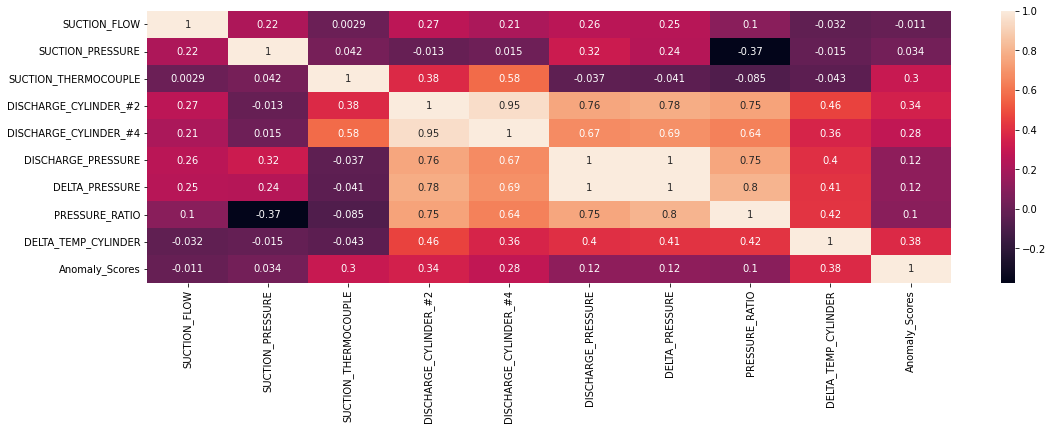

In [217]:
sns.heatmap(df.drop('clusters', axis=1).corr(), annot=True)
plt.show()

In [218]:
df.isnull().sum()

SUCTION_FLOW             0
SUCTION_PRESSURE         0
SUCTION_THERMOCOUPLE     0
DISCHARGE_CYLINDER_#2    0
DISCHARGE_CYLINDER_#4    0
DISCHARGE_PRESSURE       0
DELTA_PRESSURE           0
PRESSURE_RATIO           0
DELTA_TEMP_CYLINDER      0
clusters                 0
Anomaly_Scores           0
dtype: int64

# Saving the Csv scores

In [229]:
df.head(2)

SUCTION_FLOW  SUCTION_PRESSURE  SUCTION_THERMOCOUPLE  \
time_stamp                                                                  
2019-01-01 04:00:00      8.814003          5.194933             35.289555   
2019-01-01 08:00:00      8.655781          4.830067             34.667764   

                     DISCHARGE_CYLINDER_#2  DISCHARGE_CYLINDER_#4  \
time_stamp                                                          
2019-01-01 04:00:00             192.875322             186.063029   
2019-01-01 08:00:00             192.719074             185.645106   

                     DISCHARGE_PRESSURE  DELTA_PRESSURE  PRESSURE_RATIO  \
time_stamp                                                                
2019-01-01 04:00:00           50.333333       45.138401        9.712325   
2019-01-01 08:00:00           49.170833       44.340766       10.216795   

                     DELTA_TEMP_CYLINDER  clusters  Anomaly_Scores  
time_stamp                                                          
2019-01-01 04:00:00             6.812293         8        0.107098  
2019-01-01 08:00:00             7.073968         8        0.126089

In [230]:
# %%time

DUMP_CSV_FILE_NAME = 'Stg-1-Anomaly_Scores_v1.csv'


df.drop(['clusters'], axis=1, inplace=True)
df.to_csv(DUMP_CSV_FILE_NAME, index=True)

<AxesSubplot:>

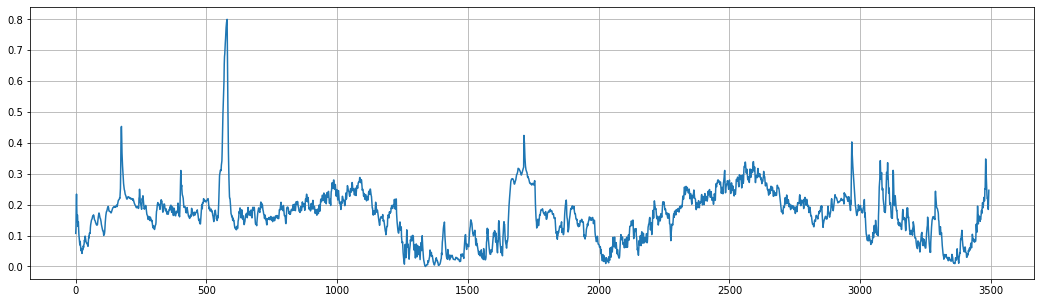

In [231]:
pd.read_csv(DUMP_CSV_FILE_NAME)['Anomaly_Scores'].plot()

# -------------------------------------------------------------------------------------------